**Notebook 4-2-Fase 4** (v9)

Capa Silver (2): análisis de la correlación

Dataset: **2023/01**

Objetivos del presente notebook:
- Análisis de correlación, grupos C-6 y C-7
- Paso a la capa Gold

Versiones:
- v1: código traspasado desde la v2 del notebook 3
- v2: estudio de la correlación, reducción de dimensionalidad y clustering
- v3: limpieza de v2 -> problemas de memoria, lo paso a v4
- v4: gestión de memoria: no funciona
- v5: vuelvo a v3, separo en fases
- v6: limpieza de v5
- v7: reordenación de fases
- v8: no hay, paso a v9 por v9 de la Fase 2
- v9: preparación de datos para Gold; acabado

In [1]:
from pyspark.sql import SparkSession

from google.colab import drive

import os
import sys
import gc
import json

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# directorio del fichero .py con funciones compartidas de la aplicación
sys.path.append("/content/drive/MyDrive/taxi_project")

In [6]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
SILVER_DIR = f"{PROJECT_ROOT}/silver"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"
SILVER_GOLD_DIR = f"{SILVER_DIR}/for_gold"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# crea directorios si no existen
paths = [BRONZE_DIR, SILVER_DIR, METADATA_DIR, SILVER_GOLD_DIR, BRONZE_PATH]

for path in paths:
    os.makedirs(path, exist_ok=True)

In [7]:
# dataset preparado para correlaciones
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_clean_251109"

In [8]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [9]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [10]:
from silver_functions_v3 import (
    get_bronze_dataset_paths, extract_year_month_from_hive_partition, format_date_info
)

In [11]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

In [12]:
# gestión de memoria
from silver_functions_v3 import show_memory_disk, clear_all_caches

In [13]:
# carga y guardado de ficheros
from silver_functions_v3 import save_parquet, load_parquet

In [14]:
# correlación
from silver_functions_v3 import (
    compute_correlation_matrix,
    analyze_correlation_group,
    calculate_correlation_summary,
    print_correlation_summary,
    plot_correlation_heatmap,
    identify_high_correlations_from_toplist,
    analyze_correlations
)

In [15]:
# Variance Inflation Factor (VIF)
from silver_functions_v3 import (
    calculate_vif, vif_to_pandas, filter_low_vif_variables, analyze_vif
)

In [16]:
# K-Means
from silver_functions_v3 import (
    silhouette_score_spark, plot_silhouette_scores, apply_kmeans_spark
)

In [17]:
# reducción de dimensionalidad
from silver_functions_v3 import calculate_dimensionality_reduction

In [18]:
# visualización de clustering
from silver_functions_v3 import (
    plot_clusters_2d, plot_cluster_profiles, plot_cluster_distribution,
    visualize_clusters_complete, plot_clusters_3d
)

In [19]:
# preparación de datos para Gold
from silver_functions_v3 import (
    generate_metadata, save_features_table, compute_quality_metrics,
    attach_correlations_to_quality_metrics, save_quality_metrics, compute_model_metrics,
    save_clusters_table, prepare_dimensionality_metrics, save_transformations_table
)

In [20]:
# logging y limpieza
from silver_functions_v3 import save_log_metrics, clear_memory

# **1) Carga del dataset: Enero de 2023 (2023-01)**

In [21]:
# lee dataframe en formato Parquet
ds_for_correlation_clean = load_parquet(spark, dir_dataset, mostrar_info=True)

if ds_for_correlation_clean is None:
    print("❌ El DataFrame no se ha cargado correctamente.")

📖 Leyendo DataFrame desde /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_clean_251109...
✅ Dataframe cargado correctamente
📊 Registros leídos: 3066715
📋 Columnas: 31
🏷️  Nombres de columnas: ['payment_type', 'pickup_hour', 'is_weekend', 'PULocationID_encoded', 'DOLocationID_encoded', 'passenger_count_encoded', 'RatecodeID_encoded', 'trip_distance_encoded', 'extra_encoded', 'tip_amount_encoded', 'improvement_surcharge_encoded', 'mta_tax_encoded', 'total_amount_encoded', 'trip_duration_minutes_encoded', 'average_speed_mph_encoded', 'fare_per_mile_encoded', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_dayofweek', 'tpep_pickup_datetime_dayofweek_sin', 'tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_cos', 'VendorID_encoded', 'store_and_fwd_flag_encoded', 'pickup_hour_hour_sin', 'pickup_hour_hour_cos', 'tip_score_encoded', 'trip_extra_c

# **3) Correlaciones internas críticas**

## **Grupo C: Correlaciones contextuales**

### **Grupo C-6: Correlaciones cruzadas contextuales entre variables temporales y variables de servicio**

**C-6-1. Hora de recogida y número de pasajeros**

In [22]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 1.49 GB / 13.61 GB (13.4%)
[Inicio limpieza completa de memoria] Disco usado: 42.31 GB / 115.66 GB (36.6%)


[Final limpieza completa de memoria] Memoria usada: 1.34 GB / 13.61 GB (12.3%)
[Final limpieza completa de memoria] Disco usado: 42.31 GB / 115.66 GB (36.6%)



In [23]:
grupo_c61 = [
    "pickup_hour",
    "passenger_count_encoded"
]

grupo_nombre = "C61 Hora de recogida y número de pasajeros"

In [24]:
# gestión de metadatos
params = {
    "features": grupo_c61,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C61 Hora de recogida y n\u00famero de pasajeros",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "pickup_hour",
      "passenger_count_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T11:36:43.228435",
  "model_version": "b32393d4a009",
  "featureset_version": "C61 Hora de recogida y n\u00famero de pasajeros_b32393d4a009",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [25]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c61,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c61_hora_de_recogida__silver_features_20251111_113647.parquet
  Registros: 3,066,715
  Columnas: 7


In [26]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c61,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C61 HORA DE RECOGIDA Y NÚMERO DE PASAJEROS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C61 Hora de recogida y número de pasajeros
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.015
Correlación máxima: 0.015
Correlación mínima: 0.015
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


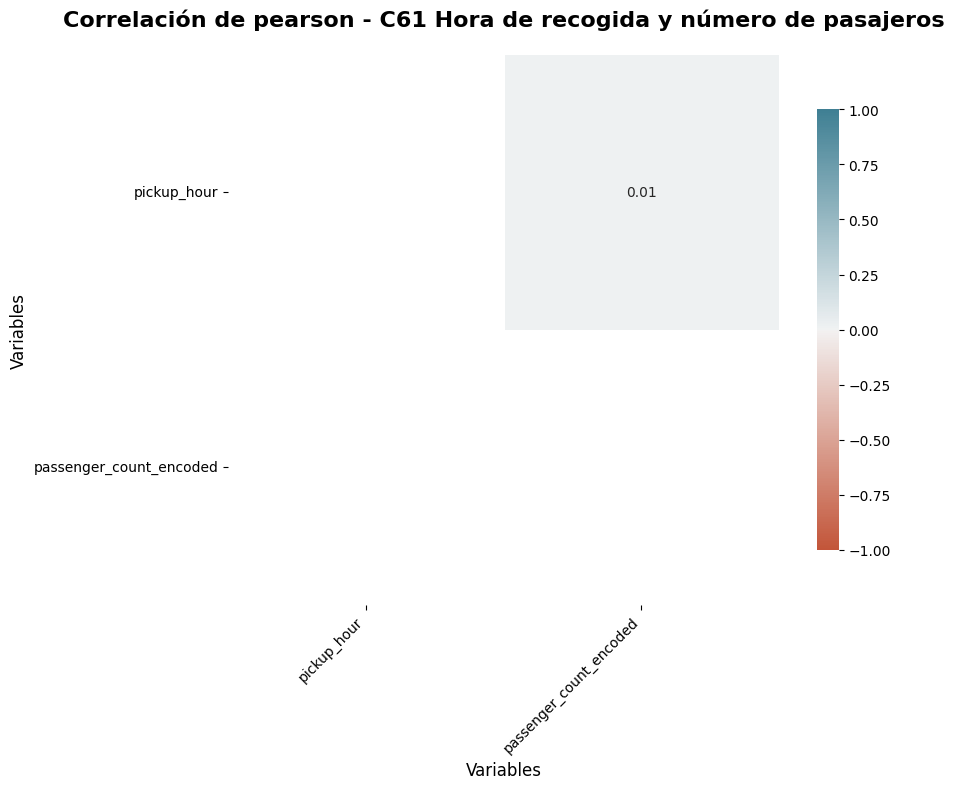


📊 ANÁLISIS DE CORRELACIÓN - C61 HORA DE RECOGIDA Y NÚMERO DE PASAJEROS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C61 Hora de recogida y número de pasajeros
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.040
Correlación máxima: 0.040
Correlación mínima: 0.040
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


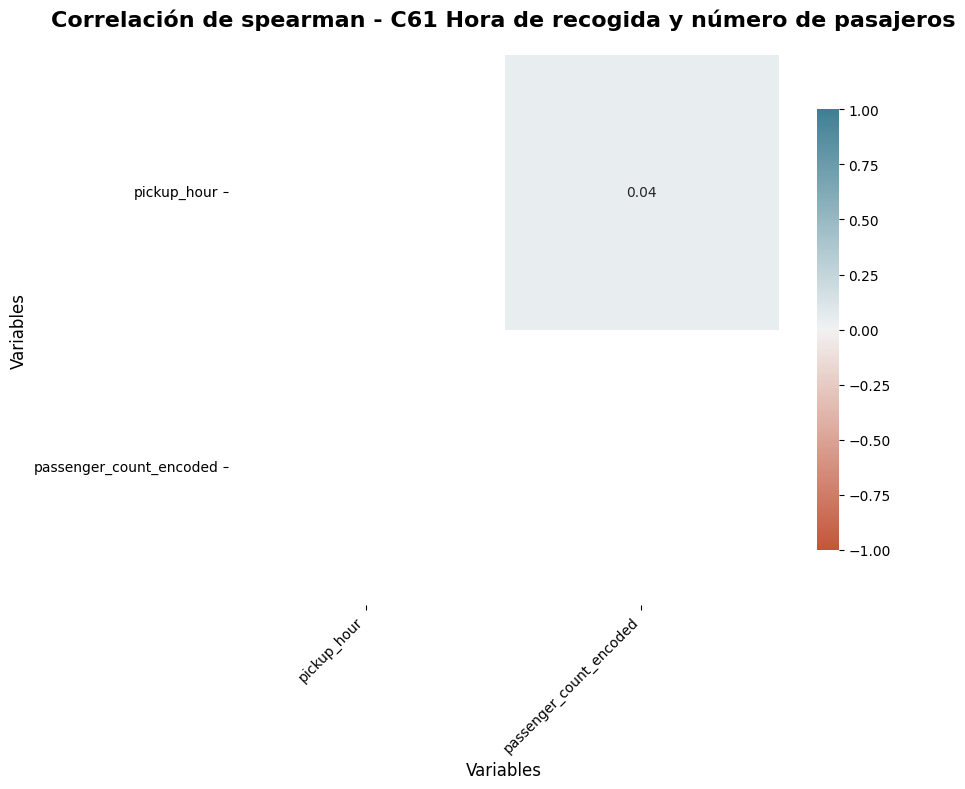

In [27]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c61,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c61,
    group_name = grupo_nombre,
    method = "spearman"
)

Variables sin correlación.

In [28]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [29]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C61 Hora de recogida y n\u00famero de pasajeros",
  "total_rows": 3066715,
  "variables": {
    "pickup_hour": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 23.0,
      "mean": 14.128930794025528,
      "median": 15.0,
      "std": 5.771471504487696,
      "q25": 11.0,
      "q75": 19.0,
      "n_outliers_iqr": 0
    },
    "passenger_count_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 8.0,
      "mean": 0.3707344829891268,
      "median": 0.0,
      "std": 0.8708899775475627,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 682451
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.01471920013588712,
        "max_correlation": 0.01471920013588712,
        "min_correlation": 0.01471920013588712,
        "std_correlation": 0.0,
        "hig

- **Análisis de VIF**

In [30]:
analyze_vif(ds_for_correlation_clean, grupo_c61)

                  Variable     VIF    Interpretacion
0              pickup_hour  1.0002  Baja correlación
1  passenger_count_encoded  1.0002  Baja correlación

=== Variables con VIF aceptable ===



['pickup_hour', 'passenger_count_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.7410
Para k = 3, la silueta media es: 0.7237
Para k = 4, la silueta media es: 0.6908
Para k = 5, la silueta media es: 0.6826
Para k = 6, la silueta media es: 0.6307
Para k = 7, la silueta media es: 0.6610
Para k = 8, la silueta media es: 0.6888


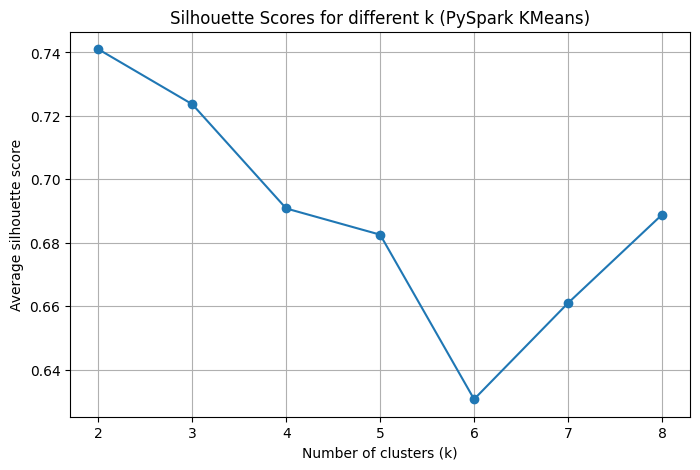

In [31]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c61, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [32]:
k_optimo = 2

In [33]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c61,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['pickup_hour', 'passenger_count_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 35957503.4575

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1096470|
|1      |1970245|
+-------+-------+


⏱️ Tiempo de ejecución: 39.67 segundos
📊 Balance de clusters - Min: 1096470,  Max: 1970245, Std: 436887.50


In [34]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.7410172492880411,
  "wssse": 35957503.45751036,
  "cluster_sizes": [
    [
      1,
      1970245
    ],
    [
      0,
      1096470
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7410172492880411,
    "3": 0.7236705231879634,
    "4": 0.6908174287148837,
    "5": 0.6825525399063574,
    "6": 0.6306827488937806,
    "7": 0.6609952454738505,
    "8": 0.6888416424699166
  },
  "centers": [
    [
      7.792697474623109,
      0.344966118544055
    ],
    [
      17.655136797707897,
      0.3850749526074168
    ]
  ]
}


In [35]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c61_hora_de_recogida__silver_clusters_20251111_120221.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [36]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c61, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [37]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


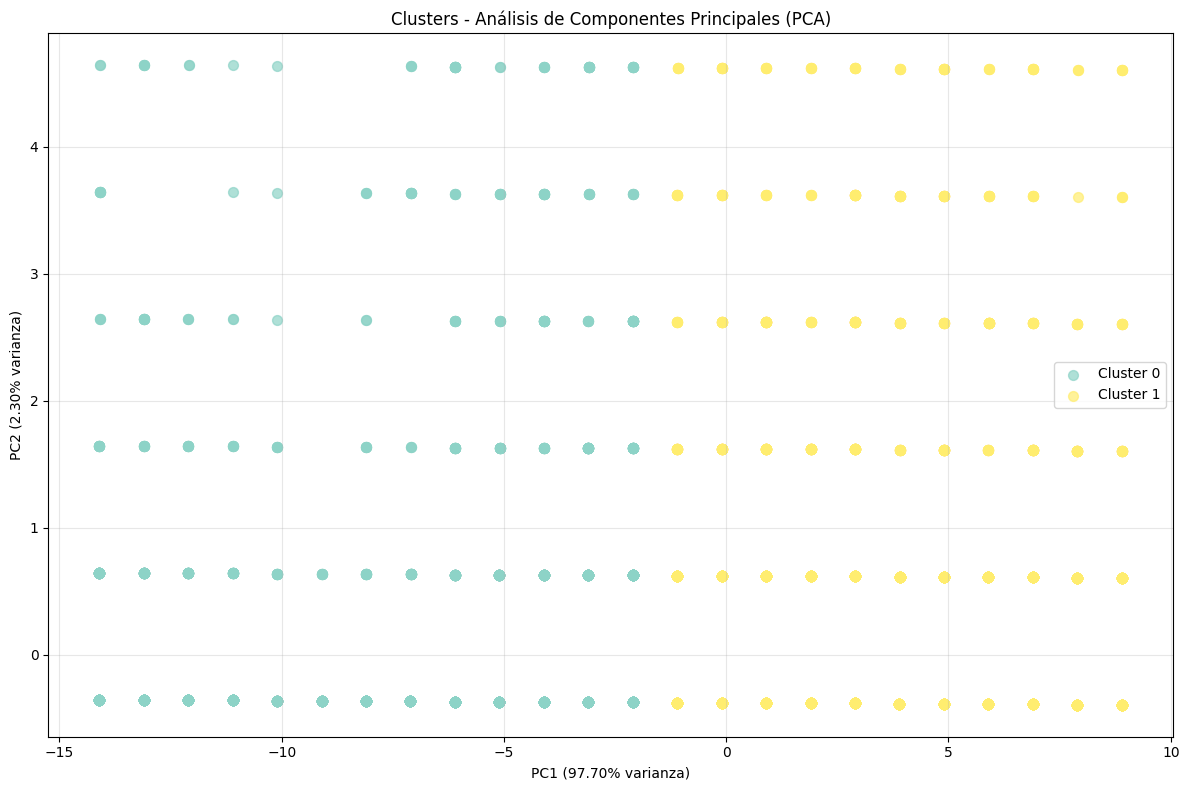

2. Perfiles de clusters...


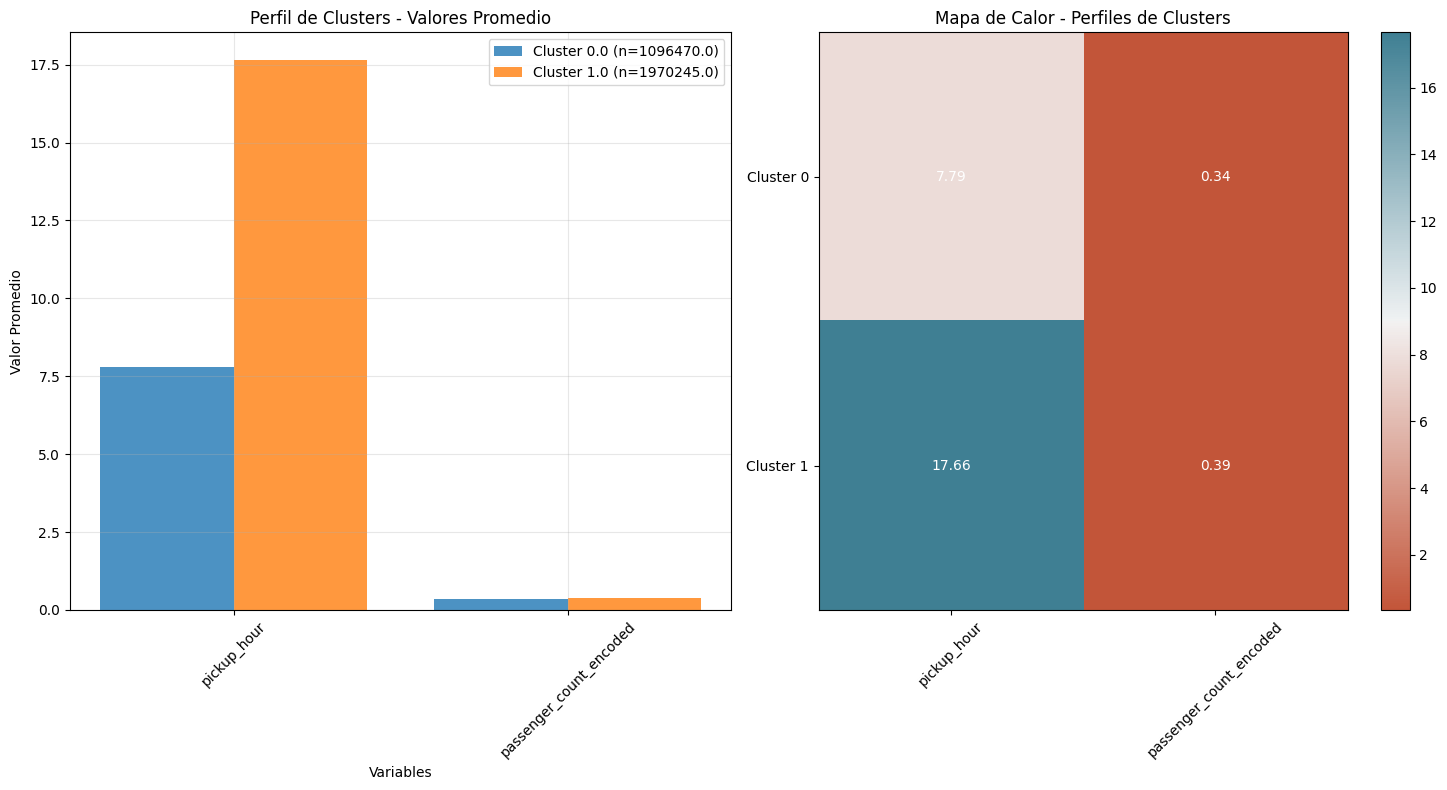

3. Distribución de clusters...


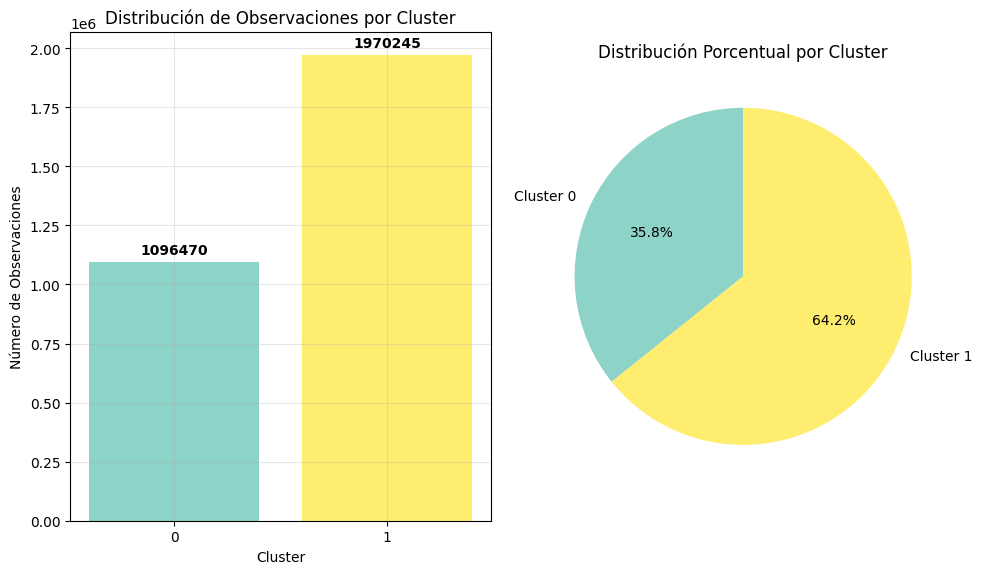

✅ Visualizaciones completadas!


In [38]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c61,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Dos grupos separados, PC1 obtiene casi el 98% de la varianza.

Relación 60-40 entre la distribución de ambos grupos; el mayor de ellos tiene valores más altos de hora de recogida. El número de pasajeros entre ellos es parecido, por lo que los clusters en realidad no representan un comportamiento útil con respecto a los pasajeros, PCA sólo diferencia de forma arbitraria las horas en los grupos.

El grupo mayoritario corresponderá a horas de la tarde, y el segundo grupo a la noche y la mañana.

In [39]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [40]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c61_hora_de_recogida__silver_transformations_pca_20251111_120345.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [41]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c61_hora_de_recogida__silver_logs_20251111_120347.parquet
  Total de registros en log: 1


In [42]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.25 GB / 13.61 GB (48.4%)
[Inicio] Disco usado: 42.42 GB / 115.66 GB (36.7%)


[Final] Memoria usada: 6.25 GB / 13.61 GB (48.4%)
[Final] Disco usado: 42.42 GB / 115.66 GB (36.7%)



In [43]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.25 GB / 13.61 GB (48.4%)
[Inicio limpieza completa de memoria] Disco usado: 42.42 GB / 115.66 GB (36.7%)


[Final limpieza completa de memoria] Memoria usada: 2.10 GB / 13.61 GB (17.9%)
[Final limpieza completa de memoria] Disco usado: 42.42 GB / 115.66 GB (36.7%)



**C-6-2. Fin de semana y distancia**

In [44]:
grupo_c62 = [
    "is_weekend",
    "trip_distance_encoded"
]

grupo_nombre = "C62 Fin de semana y distancia"

In [45]:
# gestión de metadatos
params = {
    "features": grupo_c62,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C62 Fin de semana y distancia",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "is_weekend",
      "trip_distance_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T12:03:50.731268",
  "model_version": "e2e58cb7fcd8",
  "featureset_version": "C62 Fin de semana y distancia_e2e58cb7fcd8",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [46]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c62,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c62_fin_de_semana_y___silver_features_20251111_120351.parquet
  Registros: 3,066,715
  Columnas: 7


In [47]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c62,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C62 FIN DE SEMANA Y DISTANCIA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C62 Fin de semana y distancia
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.001
Correlación máxima: 0.001
Correlación mínima: 0.001
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


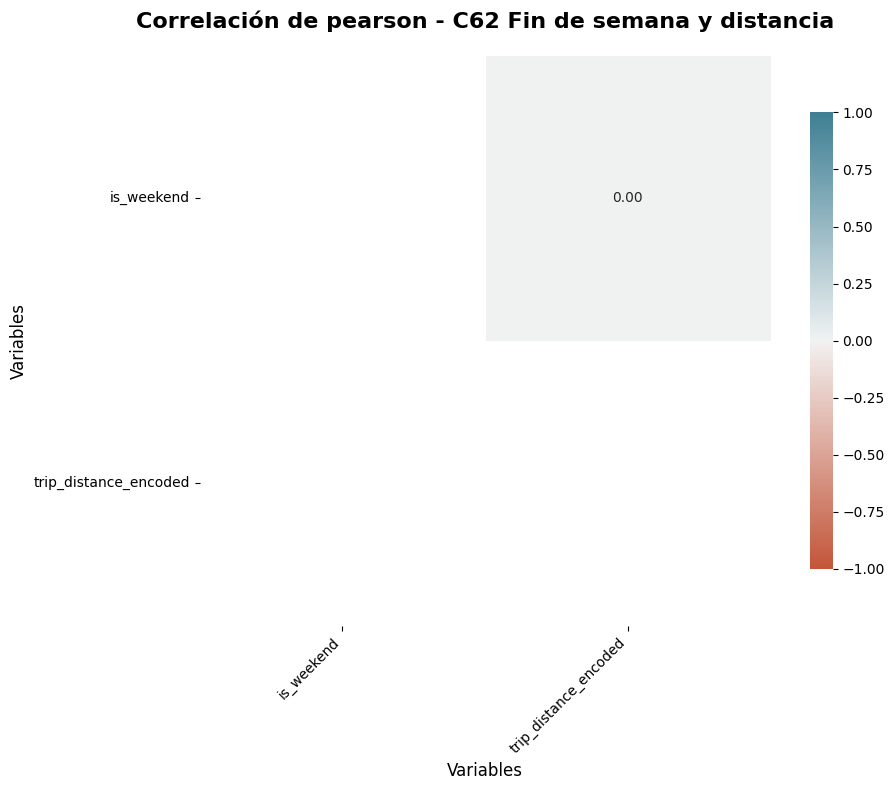


📊 ANÁLISIS DE CORRELACIÓN - C62 FIN DE SEMANA Y DISTANCIA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C62 Fin de semana y distancia
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.036
Correlación máxima: 0.036
Correlación mínima: 0.036
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


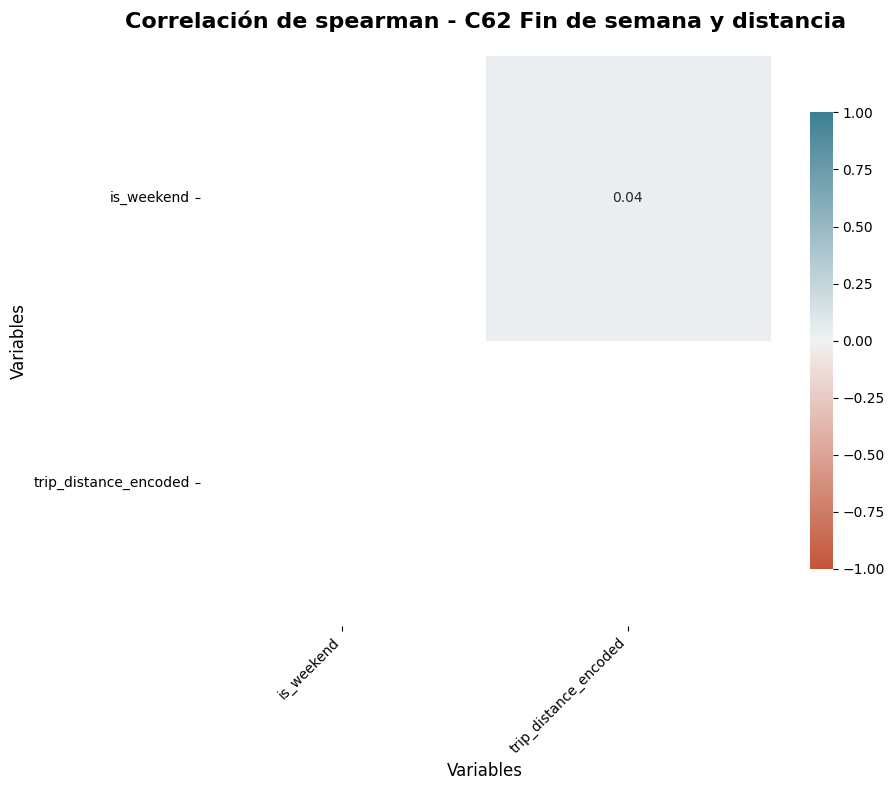

In [48]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c62,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c62,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación.

In [49]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [50]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C62 Fin de semana y distancia",
  "total_rows": 3066715,
  "variables": {
    "is_weekend": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 1.0,
      "mean": 0.2863207047280233,
      "median": 0.0,
      "std": 0.45204117666869836,
      "q25": 0.0,
      "q75": 1.0,
      "n_outliers_iqr": 0
    },
    "trip_distance_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.015504785875246022,
      "max": 1037.371977155861,
      "mean": -1.6782906439206588e-16,
      "median": -0.008333206947302121,
      "std": 0.9999999999999981,
      "q25": -0.011257929079927285,
      "q75": -0.002323503935058629,
      "n_outliers_iqr": 573232
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.0006626056754756506,
        "max_correlation": 0.0006626056754756506,
        "min_correla

- **Análisis de VIF**

In [51]:
analyze_vif(ds_for_correlation_clean, grupo_c62)

                Variable  VIF    Interpretacion
0             is_weekend  1.0  Baja correlación
1  trip_distance_encoded  1.0  Baja correlación

=== Variables con VIF aceptable ===



['is_weekend', 'trip_distance_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.1359
Para k = 3, la silueta media es: 0.8858
Para k = 4, la silueta media es: 0.9779
Para k = 5, la silueta media es: 0.9833
Para k = 6, la silueta media es: 0.9833
Para k = 7, la silueta media es: 0.9833
Para k = 8, la silueta media es: 0.9833


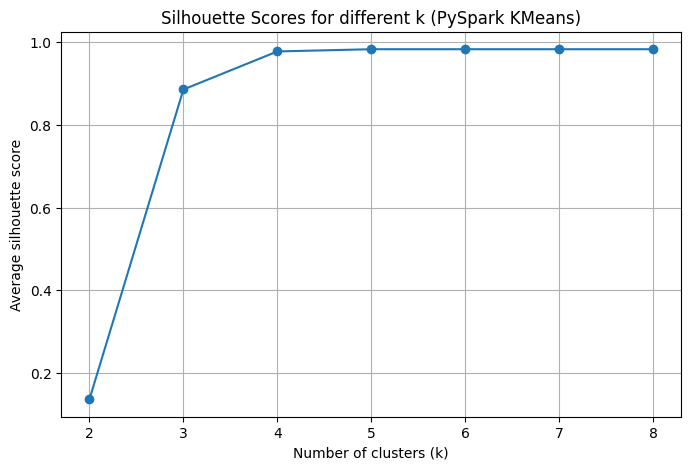

In [52]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c62, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [53]:
k_optimo = 4

In [54]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c62,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 4
- Variables utilizadas: ['is_weekend', 'trip_distance_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 148406.8003

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2188646|
|1      |3      |
|2      |5      |
|3      |878061 |
+-------+-------+


⏱️ Tiempo de ejecución: 35.79 segundos
📊 Balance de clusters - Min: 3,  Max: 2188646, Std: 895820.46


Dos clusters sin apenas registros.

In [55]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 4,
  "silhouette_score": 0.9778977766470087,
  "wssse": 148406.80032043936,
  "cluster_sizes": [
    [
      1,
      3
    ],
    [
      3,
      878061
    ],
    [
      2,
      5
    ],
    [
      0,
      2188646
    ]
  ],
  "silhouette_all_k": {
    "2": 0.13593068484587637,
    "3": 0.8857534690750437,
    "4": 0.9778977766470087,
    "5": 0.9832578230144368,
    "6": 0.983257356232295,
    "7": 0.9832569250305628,
    "8": 0.9832562580906937
  },
  "centers": [
    [
      0.0,
      -0.0014994004434074355
    ],
    [
      0.6666666666666666,
      898.4856037596206
    ],
    [
      0.2,
      315.1106125117245
    ],
    [
      0.9999999999999999,
      -0.0011267475619277532
    ]
  ]
}


In [56]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c62_fin_de_semana_y___silver_clusters_20251111_121153.parquet
  Registros: 3,066,715
  Clusters únicos: 4


- **Reducción de dimensionalidad**

In [57]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c62, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [58]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


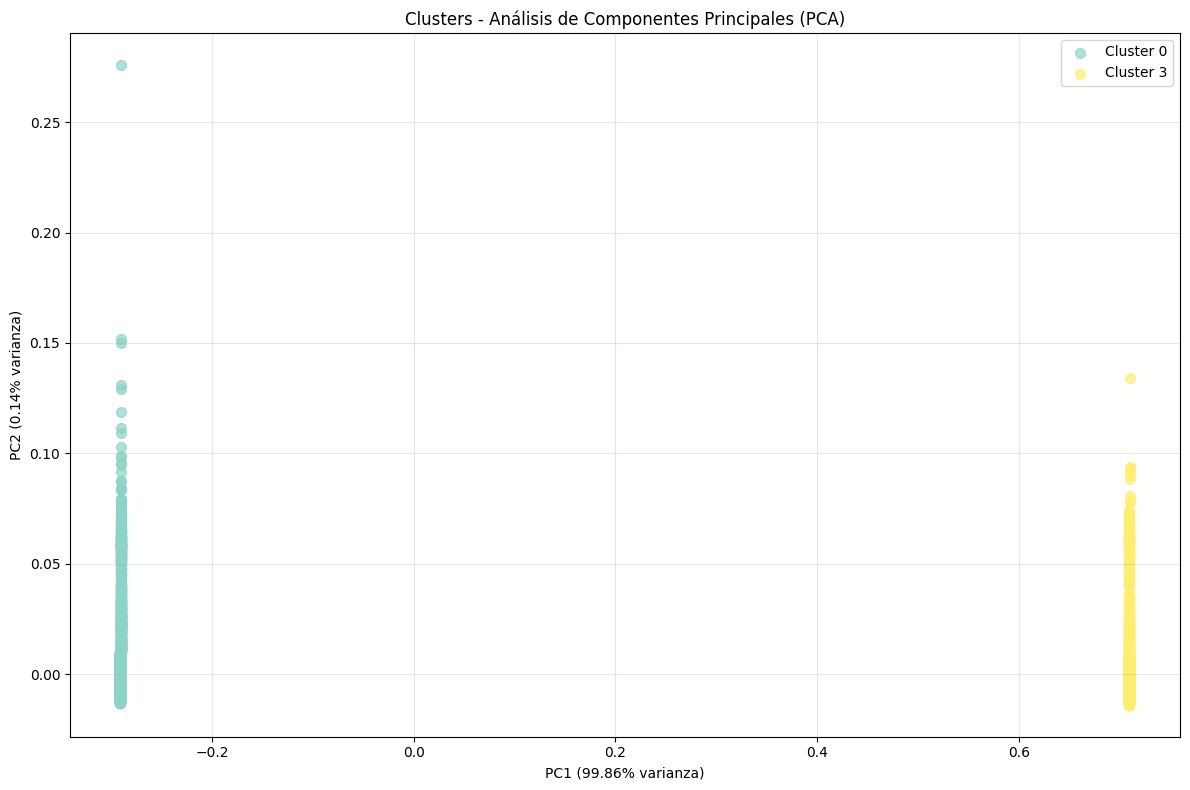

2. Perfiles de clusters...


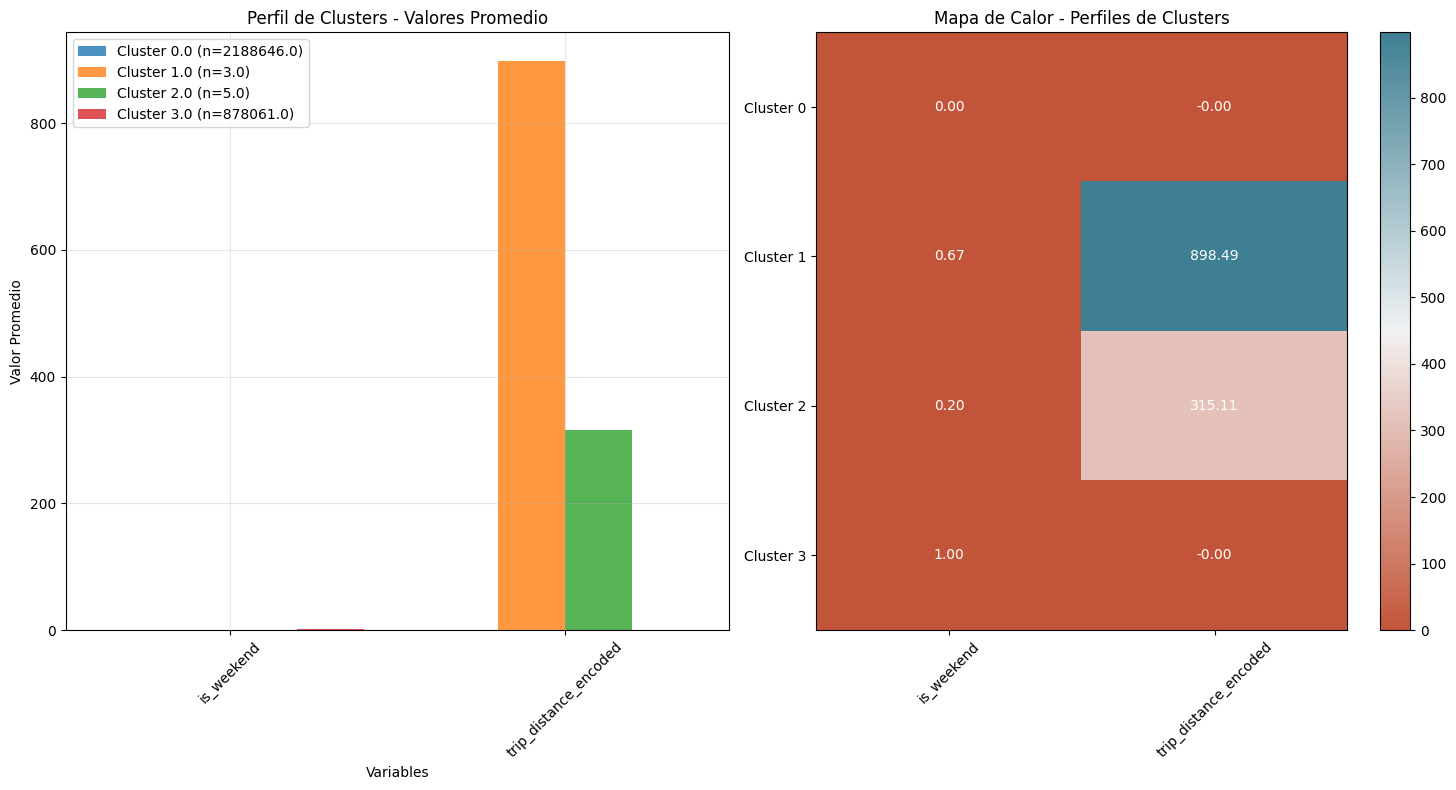

3. Distribución de clusters...


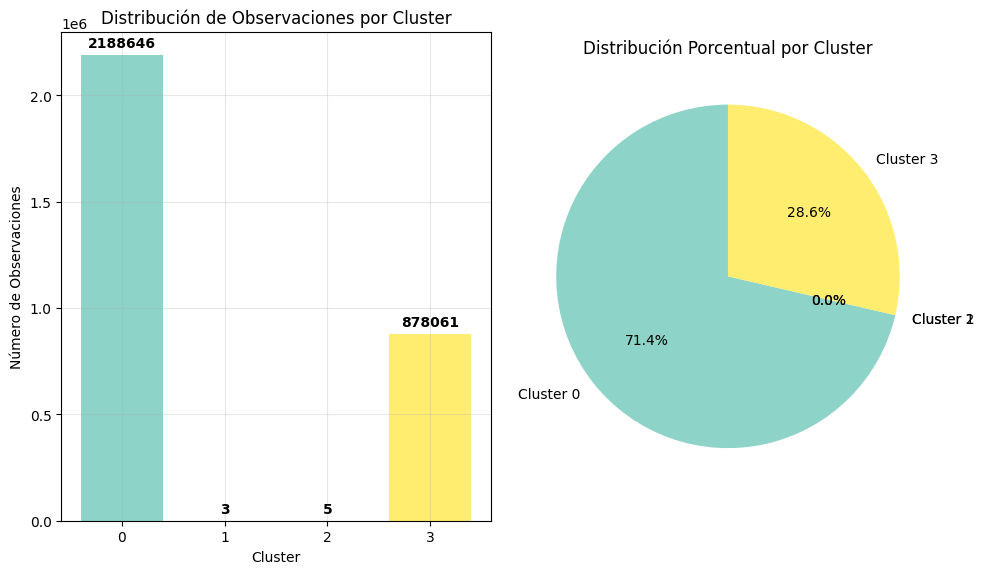

✅ Visualizaciones completadas!


In [59]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c62,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

PCA muestra dos grupos separados, PC1 obtiene el 99% de la varianza.

Un grupo mayoritario para los días fuera del fin de semana, y el otro grupo para el fin de semana. Además hay dos grupos muy minoritarios, que destacan por la elevada distancia del trayecto.

Entre los dos grupos principales no hay diferencia en cuanto a las distancias recorridas.

In [60]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [61]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c62_fin_de_semana_y___silver_transformations_pca_20251111_121453.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [62]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c62_fin_de_semana_y___silver_logs_20251111_121454.parquet
  Total de registros en log: 1


In [63]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.22 GB / 13.61 GB (48.2%)
[Inicio] Disco usado: 42.46 GB / 115.66 GB (36.7%)


[Final] Memoria usada: 6.22 GB / 13.61 GB (48.2%)
[Final] Disco usado: 42.46 GB / 115.66 GB (36.7%)



In [64]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.22 GB / 13.61 GB (48.2%)
[Inicio limpieza completa de memoria] Disco usado: 42.46 GB / 115.66 GB (36.7%)


[Final limpieza completa de memoria] Memoria usada: 2.15 GB / 13.61 GB (18.3%)
[Final limpieza completa de memoria] Disco usado: 42.46 GB / 115.66 GB (36.7%)



**C-6-3. Día de la semana y velocidad media**

In [65]:
grupo_c63 = [
    "tpep_pickup_datetime_dayofweek",
    "average_speed_mph_encoded"
]

grupo_nombre = "C63 Día de la semana y velocidad media"

In [66]:
# gestión de metadatos
params = {
    "features": grupo_c63,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C63 D\u00eda de la semana y velocidad media",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tpep_pickup_datetime_dayofweek",
      "average_speed_mph_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T12:14:59.083417",
  "model_version": "945b56348c26",
  "featureset_version": "C63 D\u00eda de la semana y velocidad media_945b56348c26",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [67]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c63,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c63_día_de_la_semana__silver_features_20251111_121459.parquet
  Registros: 3,066,715
  Columnas: 7


In [68]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c63,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C63 DÍA DE LA SEMANA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C63 Día de la semana y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.108
Correlación máxima: -0.108
Correlación mínima: -0.108
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


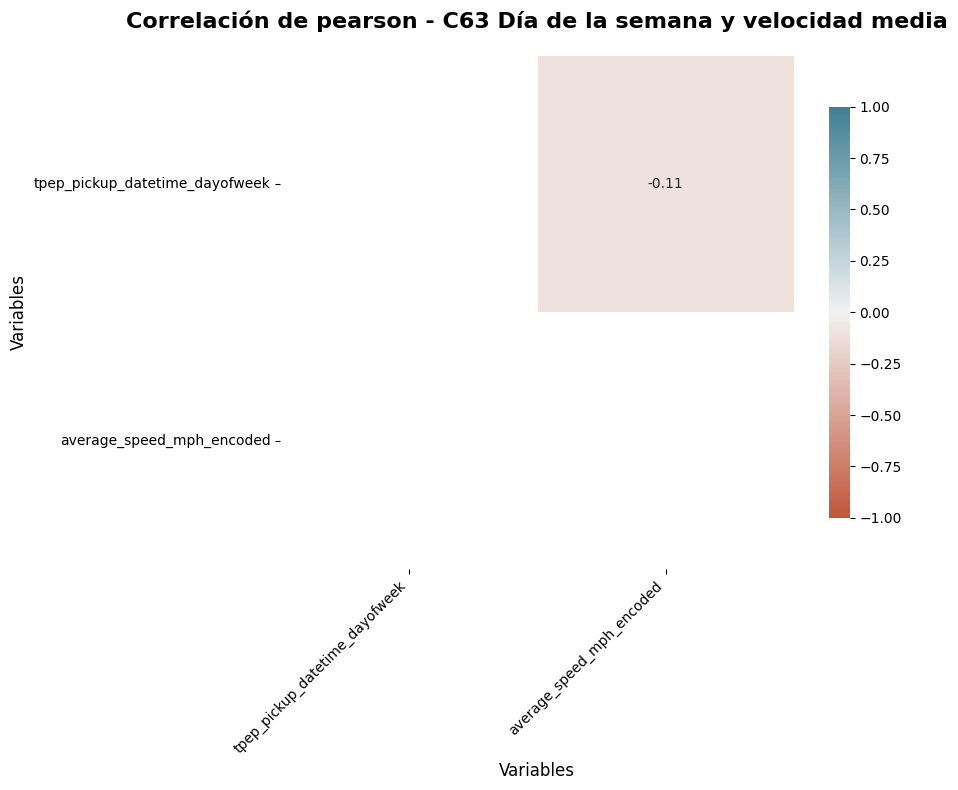


📊 ANÁLISIS DE CORRELACIÓN - C63 DÍA DE LA SEMANA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C63 Día de la semana y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.112
Correlación máxima: -0.112
Correlación mínima: -0.112
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


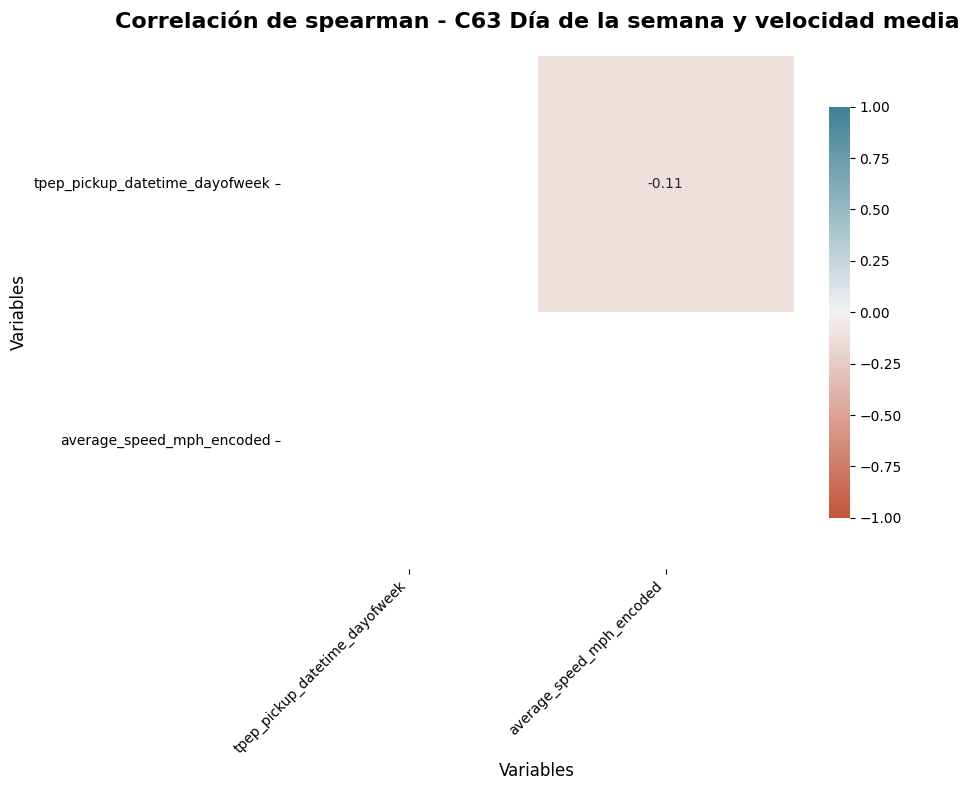

In [69]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c63,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c63,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación.

In [70]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [71]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C63 D\u00eda de la semana y velocidad media",
  "total_rows": 3066715,
  "variables": {
    "tpep_pickup_datetime_dayofweek": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 1.0,
      "max": 7.0,
      "mean": 4.008377694047214,
      "median": 4.0,
      "std": 1.9938890811936483,
      "q25": 2.0,
      "q75": 6.0,
      "n_outliers_iqr": 0
    },
    "average_speed_mph_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.817246358328061,
      "max": 4.330080642672282,
      "mean": -1.5392670307111868e-14,
      "median": -0.2882736688325687,
      "std": 0.9999999999999853,
      "q25": -0.6513810950775647,
      "q75": 0.2602028025030019,
      "n_outliers_iqr": 516638
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": -0.10824001969775064,
        "max_correlation": -0.108240019697750

- **Análisis de VIF**

In [72]:
analyze_vif(ds_for_correlation_clean, grupo_c63)

                         Variable     VIF    Interpretacion
0  tpep_pickup_datetime_dayofweek  1.0119  Baja correlación
1       average_speed_mph_encoded  1.0119  Baja correlación

=== Variables con VIF aceptable ===



['tpep_pickup_datetime_dayofweek', 'average_speed_mph_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.6953
Para k = 3, la silueta media es: 0.6679
Para k = 4, la silueta media es: 0.6272
Para k = 5, la silueta media es: 0.5917
Para k = 6, la silueta media es: 0.6115
Para k = 7, la silueta media es: 0.6400
Para k = 8, la silueta media es: 0.6023


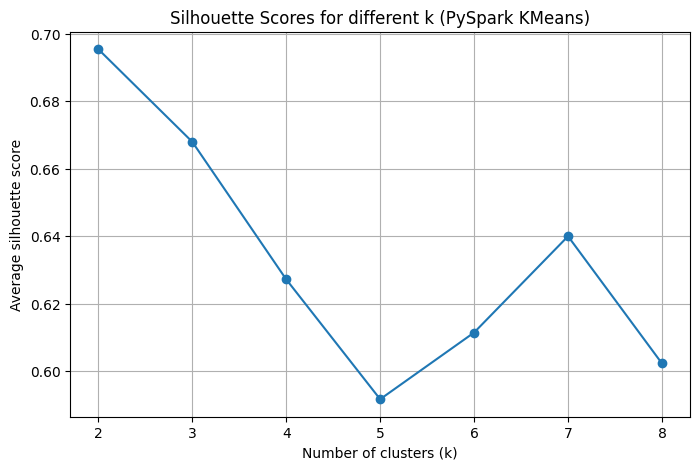

In [73]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c63, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [74]:
k_optimo = 2

In [75]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c63,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['tpep_pickup_datetime_dayofweek', 'average_speed_mph_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 6105054.7642

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1339820|
|1      |1726895|
+-------+-------+


⏱️ Tiempo de ejecución: 41.02 segundos
📊 Balance de clusters - Min: 1339820,  Max: 1726895, Std: 193537.50


In [76]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.6953486444194276,
  "wssse": 6105054.764235463,
  "cluster_sizes": [
    [
      1,
      1726895
    ],
    [
      0,
      1339820
    ]
  ],
  "silhouette_all_k": {
    "2": 0.6953486444194276,
    "3": 0.667925895826277,
    "4": 0.6271985720508483,
    "5": 0.5917087751372292,
    "6": 0.6114519726683338,
    "7": 0.6399667857897849,
    "8": 0.602300403978339
  },
  "centers": [
    [
      2.0520861477283074,
      0.14142193566926367
    ],
    [
      5.526212347492033,
      -0.10972552384636931
    ]
  ]
}


In [77]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c63_día_de_la_semana__silver_clusters_20251111_122642.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [78]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c63, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [79]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


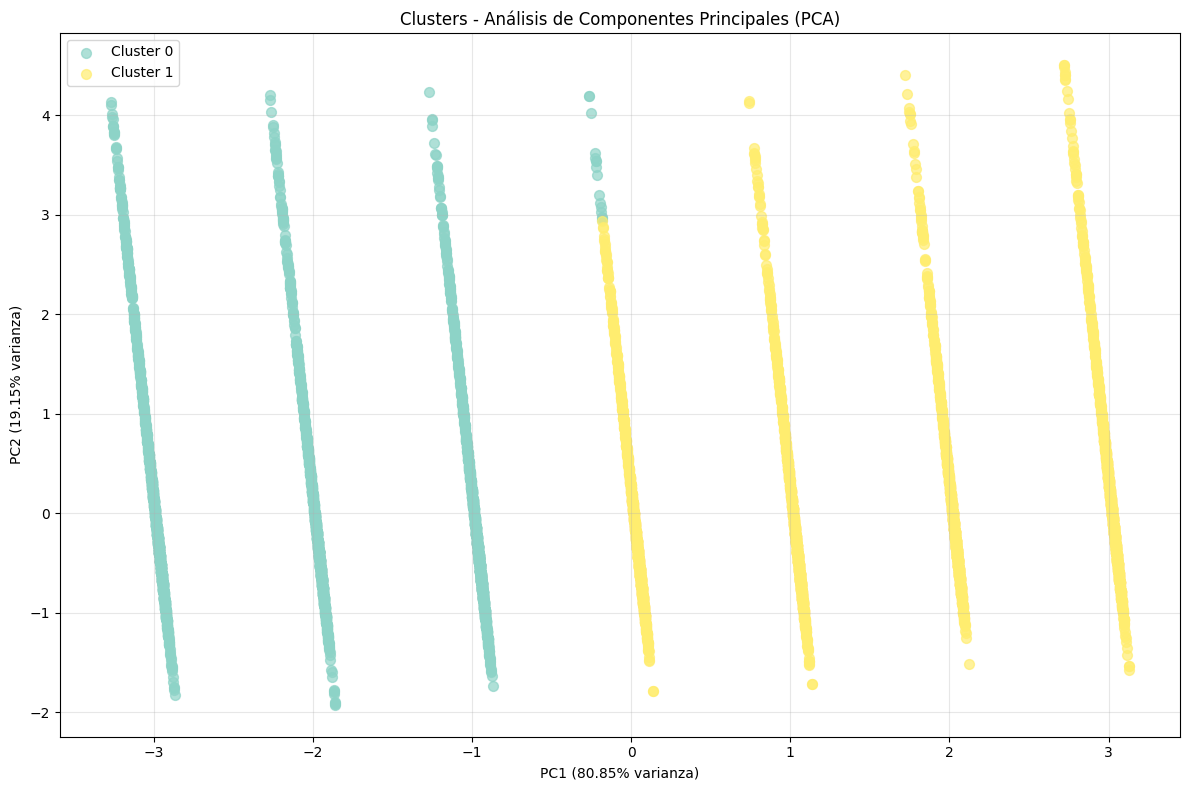

2. Perfiles de clusters...


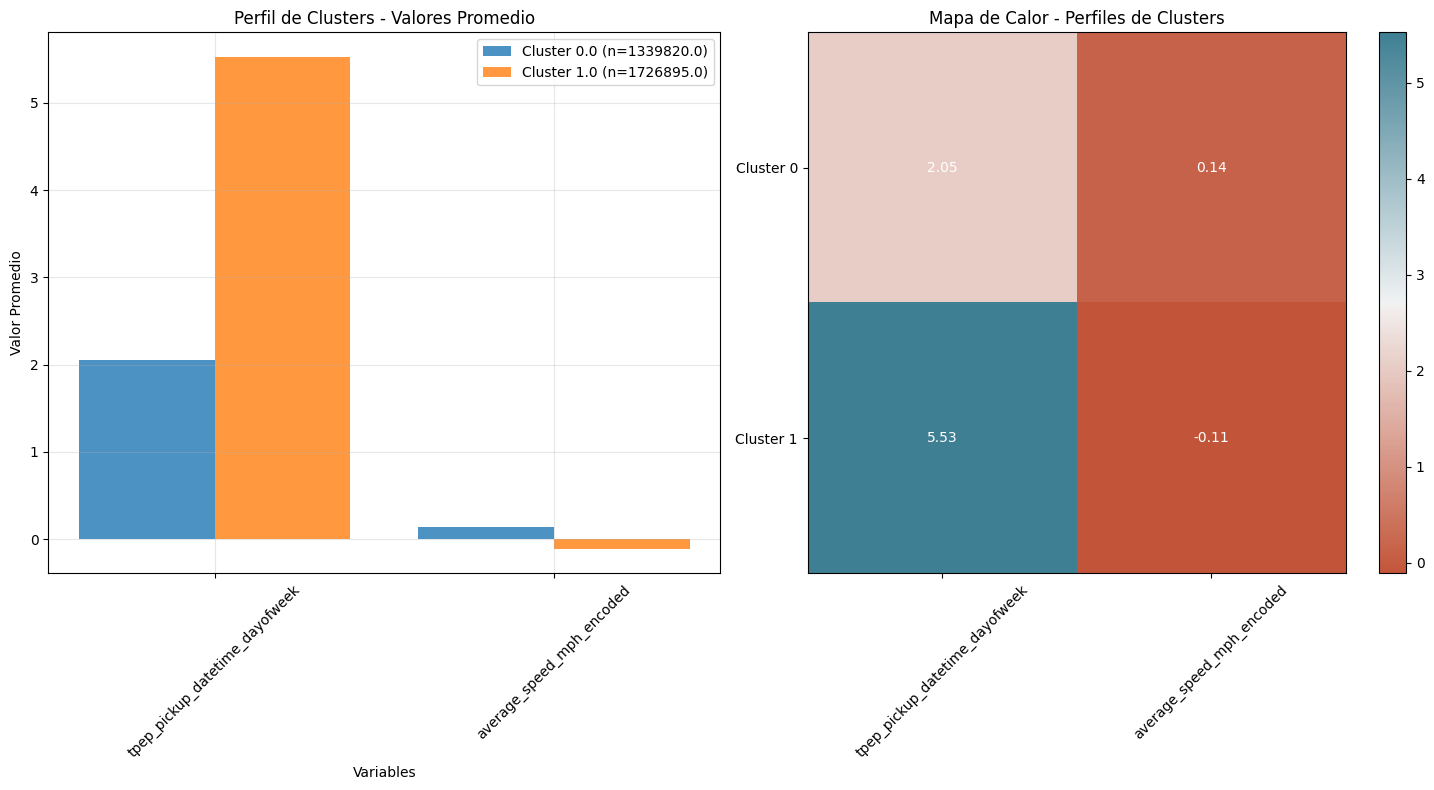

3. Distribución de clusters...


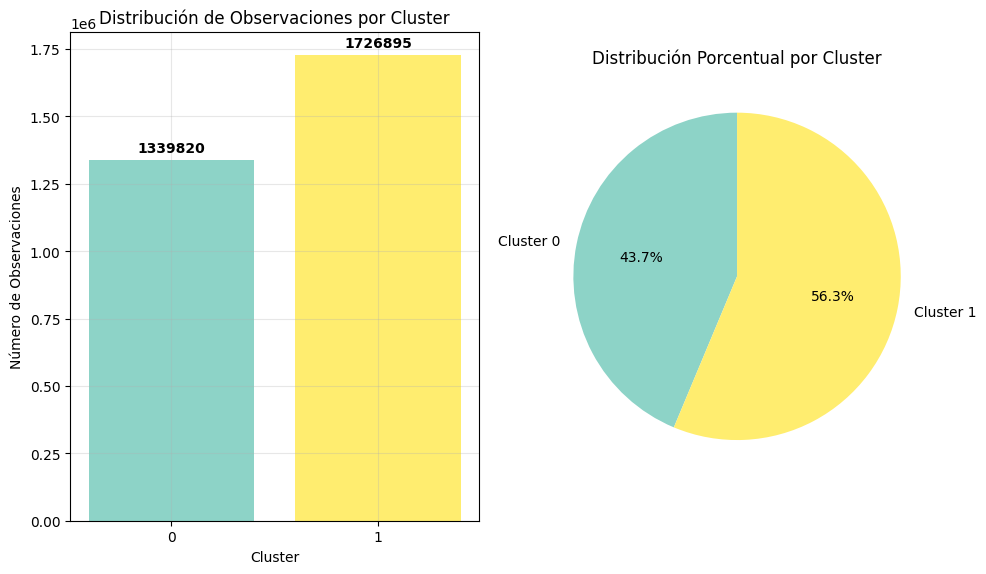

✅ Visualizaciones completadas!


In [80]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c63,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Dos grupos separados, PC1 tiene el 80% de la varianza.

No hay una diferencia muy elevada en cuanto al número de registros de cada grupo, el de más registros corresponde a la segunda mitad de la semana, y la velocidad es sólo ligeramente inferior a la del grupo de la primera mitad de la semana.

In [81]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [82]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c63_día_de_la_semana__silver_transformations_pca_20251111_123016.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [83]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c63_día_de_la_semana__silver_logs_20251111_123018.parquet
  Total de registros en log: 1


In [84]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.33 GB / 13.61 GB (49.0%)
[Inicio] Disco usado: 42.51 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.33 GB / 13.61 GB (49.0%)
[Final] Disco usado: 42.51 GB / 115.66 GB (36.8%)



In [85]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.33 GB / 13.61 GB (49.0%)
[Inicio limpieza completa de memoria] Disco usado: 42.51 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.15 GB / 13.61 GB (18.3%)
[Final limpieza completa de memoria] Disco usado: 42.51 GB / 115.66 GB (36.8%)



**C-6-4. Hora de recogida y peaje**

In [86]:
grupo_c64 = [
    "pickup_hour",
    "toll_indicator_encoded"
]

grupo_nombre = "C64 Hora de recogida y peaje"

In [87]:
# gestión de metadatos
params = {
    "features": grupo_c64,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C64 Hora de recogida y peaje",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "pickup_hour",
      "toll_indicator_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T12:30:23.940487",
  "model_version": "8499fe1815c2",
  "featureset_version": "C64 Hora de recogida y peaje_8499fe1815c2",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [88]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c64,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c64_hora_de_recogida__silver_features_20251111_123024.parquet
  Registros: 3,066,715
  Columnas: 7


In [89]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c64,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C64 HORA DE RECOGIDA Y PEAJE
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C64 Hora de recogida y peaje
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.001
Correlación máxima: -0.001
Correlación mínima: -0.001
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


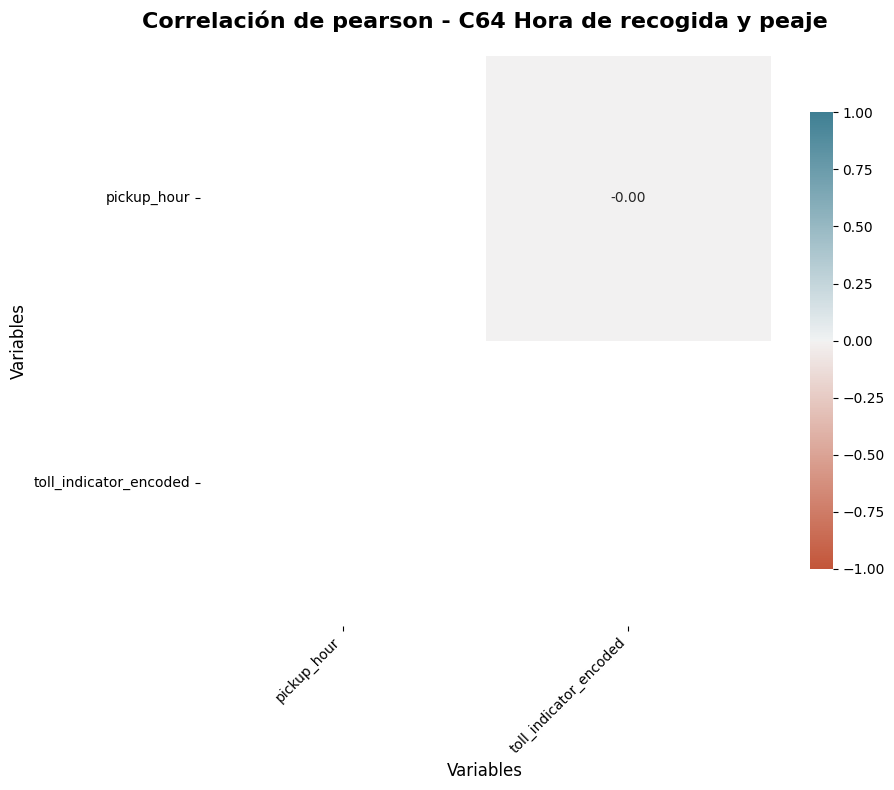


📊 ANÁLISIS DE CORRELACIÓN - C64 HORA DE RECOGIDA Y PEAJE
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C64 Hora de recogida y peaje
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.009
Correlación máxima: -0.009
Correlación mínima: -0.009
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


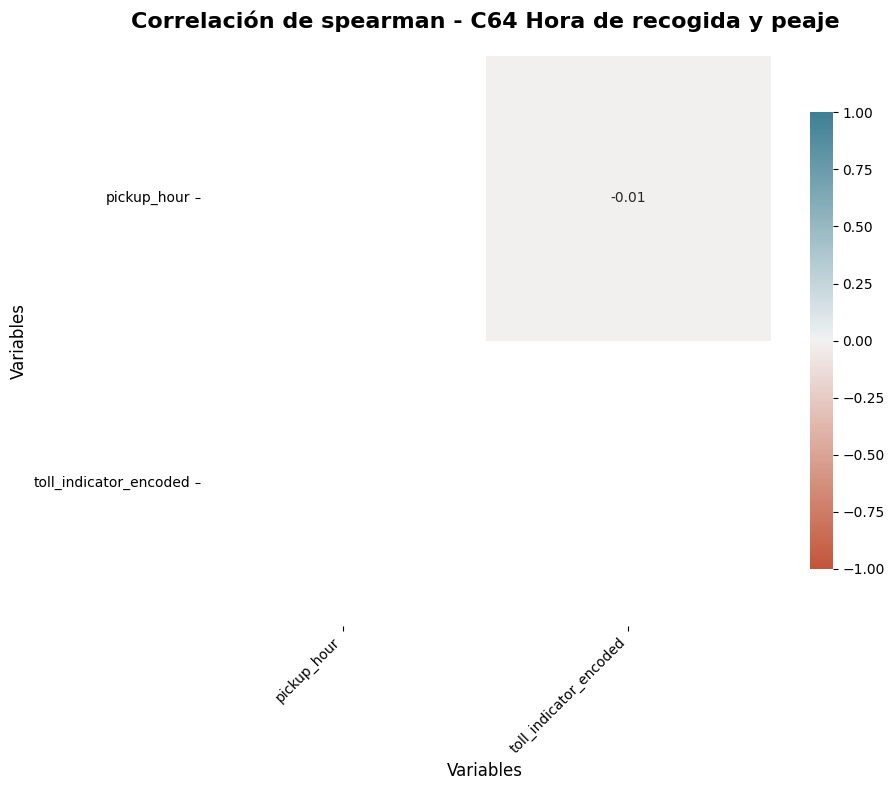

In [90]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c64,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c64,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación.

In [91]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [92]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C64 Hora de recogida y peaje",
  "total_rows": 3066715,
  "variables": {
    "pickup_hour": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 23.0,
      "mean": 14.128930794025528,
      "median": 15.0,
      "std": 5.771471504487696,
      "q25": 11.0,
      "q75": 19.0,
      "n_outliers_iqr": 0
    },
    "toll_indicator_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 1.0,
      "mean": 0.07374959851176259,
      "median": 0.0,
      "std": 0.26136299949679354,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 226169
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": -0.0013162932267267156,
        "max_correlation": -0.0013162932267267156,
        "min_correlation": -0.0013162932267267156,
        "std_correlation": 0.0,
        "high_correla

- **Análisis de VIF**

In [93]:
analyze_vif(ds_for_correlation_clean, grupo_c64)

                 Variable  VIF    Interpretacion
0             pickup_hour  1.0  Baja correlación
1  toll_indicator_encoded  1.0  Baja correlación

=== Variables con VIF aceptable ===



['pickup_hour', 'toll_indicator_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.7505
Para k = 3, la silueta media es: 0.7402
Para k = 4, la silueta media es: 0.7312
Para k = 5, la silueta media es: 0.7369
Para k = 6, la silueta media es: 0.6955
Para k = 7, la silueta media es: 0.6901
Para k = 8, la silueta media es: 0.7088


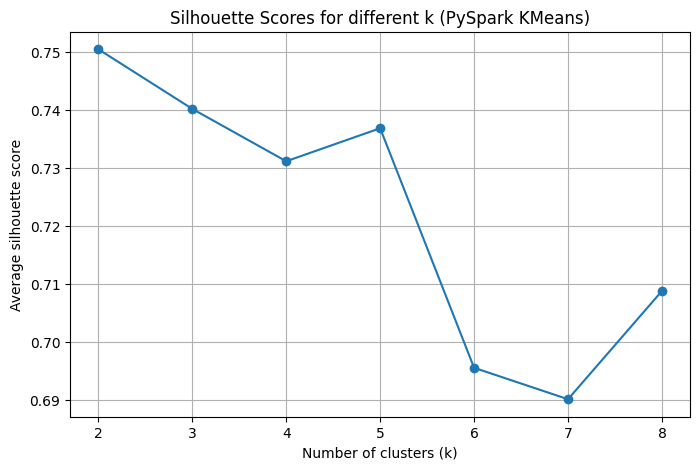

In [94]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c64, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [95]:
k_optimo = 2

In [96]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c64,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['pickup_hour', 'toll_indicator_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 33842174.2461

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1096470|
|1      |1970245|
+-------+-------+


⏱️ Tiempo de ejecución: 41.58 segundos
📊 Balance de clusters - Min: 1096470,  Max: 1970245, Std: 436887.50


In [97]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.7505392807929716,
  "wssse": 33842174.246110514,
  "cluster_sizes": [
    [
      1,
      1970245
    ],
    [
      0,
      1096470
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7505392807929716,
    "3": 0.7402289698026255,
    "4": 0.731177956949425,
    "5": 0.7368833065841656,
    "6": 0.6954848372214657,
    "7": 0.690054488735024,
    "8": 0.7087667329662412
  },
  "centers": [
    [
      7.792697474623109,
      0.07215610094211425
    ],
    [
      17.655136797707897,
      0.07463640308692573
    ]
  ]
}


In [98]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c64_hora_de_recogida__silver_clusters_20251111_124356.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [99]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c64, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [100]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


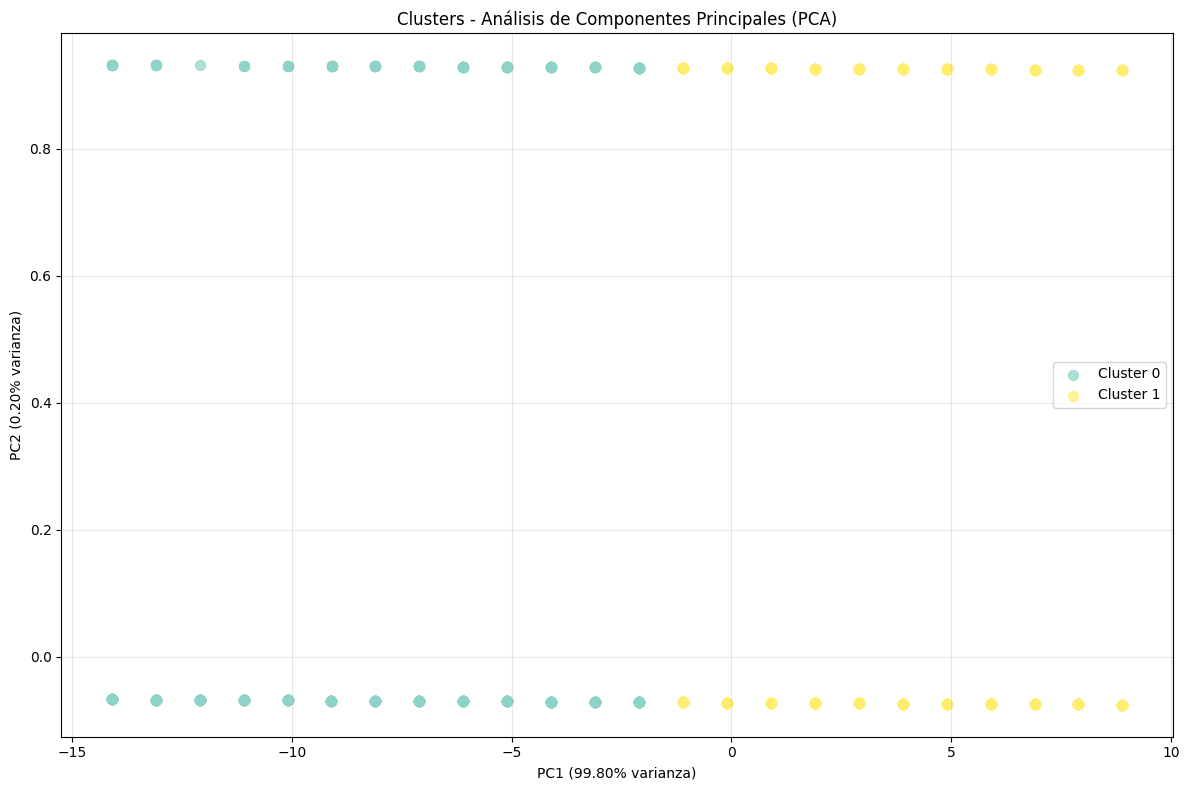

2. Perfiles de clusters...


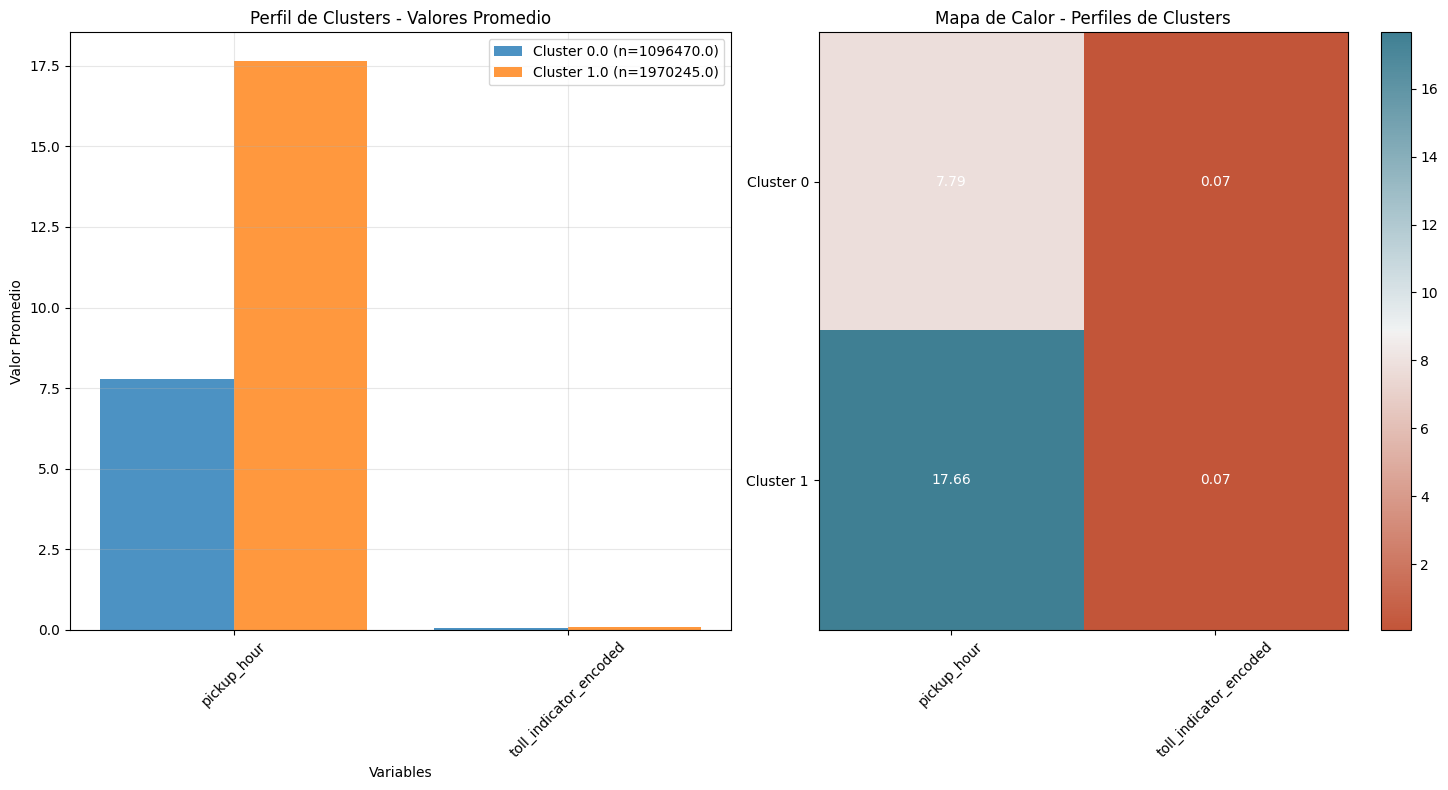

3. Distribución de clusters...


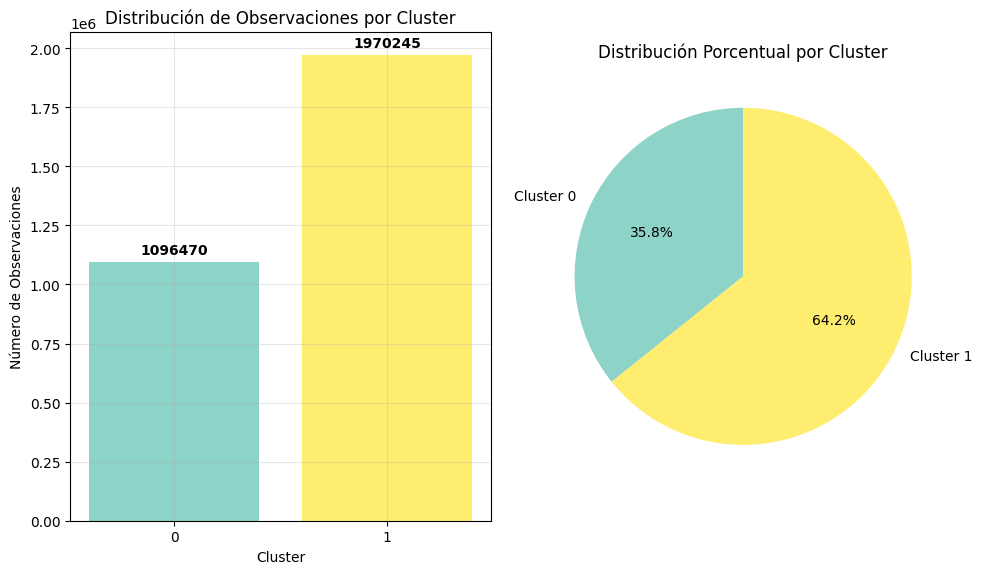

✅ Visualizaciones completadas!


In [101]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c64,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos diferenciados, PC1 obtiene el 99,8% de la varianza.

Clusters divididos por franjas horarias (uno corresponde a la noche y la mañana, el otro a la tarde), todos con un peaje similar.

In [102]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [103]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c64_hora_de_recogida__silver_transformations_pca_20251111_124626.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [104]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c64_hora_de_recogida__silver_logs_20251111_124628.parquet
  Total de registros en log: 1


In [105]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.04 GB / 13.61 GB (46.9%)
[Inicio] Disco usado: 42.54 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.04 GB / 13.61 GB (46.9%)
[Final] Disco usado: 42.54 GB / 115.66 GB (36.8%)



In [106]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.04 GB / 13.61 GB (46.9%)
[Inicio limpieza completa de memoria] Disco usado: 42.54 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.17 GB / 13.61 GB (18.4%)
[Final limpieza completa de memoria] Disco usado: 42.54 GB / 115.66 GB (36.8%)



### **Grupo C-7: Correlaciones cruzadas contextuales entre variables de costo y variables de distancia/duración**

**C-7-1. Total pagado y distancia**

In [107]:
grupo_c71 = [
    "total_amount_encoded",
    "trip_distance_encoded"
]

grupo_nombre = "C71 Total pagado y distancia"

In [108]:
# gestión de metadatos
params = {
    "features": grupo_c71,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C71 Total pagado y distancia",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "total_amount_encoded",
      "trip_distance_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T12:46:34.505335",
  "model_version": "59d96886c1f8",
  "featureset_version": "C71 Total pagado y distancia_59d96886c1f8",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [109]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c71,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c71_total_pagado_y_d__silver_features_20251111_124635.parquet
  Registros: 3,066,715
  Columnas: 7


In [110]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c71,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C71 TOTAL PAGADO Y DISTANCIA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C71 Total pagado y distancia
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.017
Correlación máxima: 0.017
Correlación mínima: 0.017
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


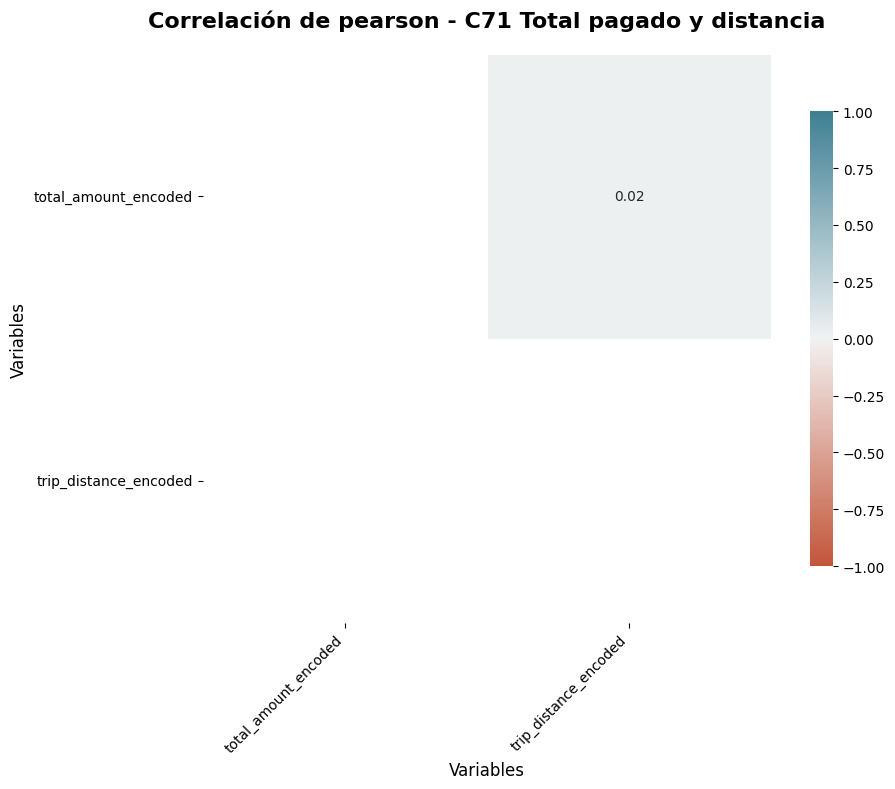


📊 ANÁLISIS DE CORRELACIÓN - C71 TOTAL PAGADO Y DISTANCIA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C71 Total pagado y distancia
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.901
Correlación máxima: 0.901
Correlación mínima: 0.901
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


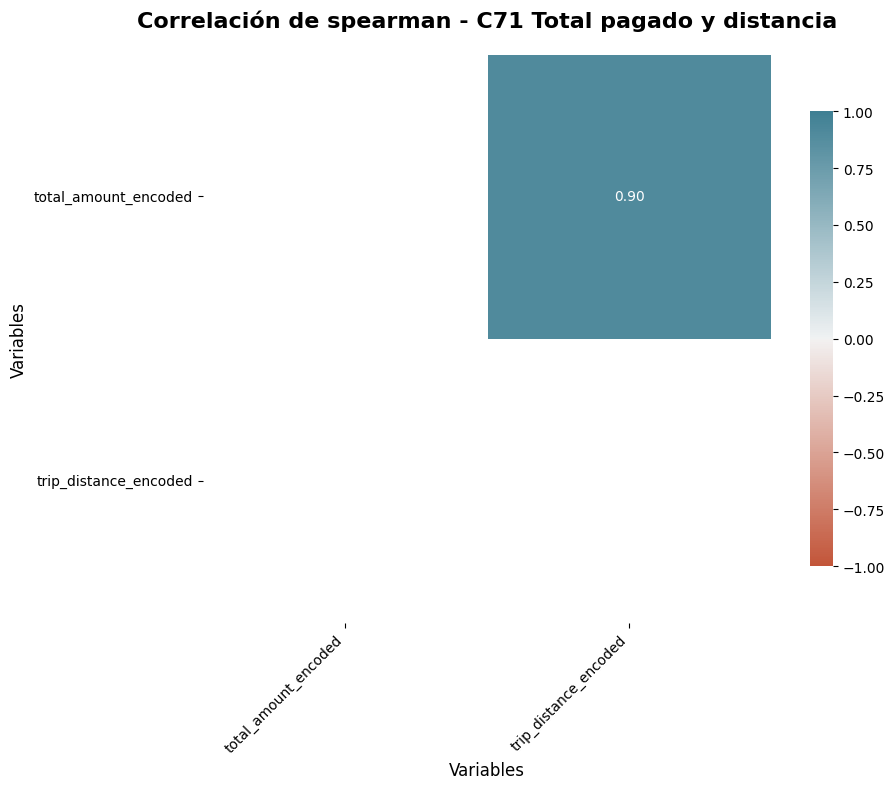

In [111]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c71,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c71,
    group_name = grupo_nombre,
    method = "spearman"
)

Hay una alta correlación no lineal entre total_amount y trip_distance: parece lógico que haya relación entre el importe total del trayecto y la distancia recorrida.

In [112]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [113]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C71 Total pagado y distancia",
  "total_rows": 3066715,
  "variables": {
    "total_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.2660716187785135,
      "max": 52.80343867624831,
      "mean": 1.086146817348318e-14,
      "median": -0.33438874784170847,
      "std": 1.000000000000057,
      "q25": -0.5544785972540753,
      "q75": 0.046607125930960135,
      "n_outliers_iqr": 541814
    },
    "trip_distance_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.015504785875246022,
      "max": 1037.371977155861,
      "mean": -1.6782906439206588e-16,
      "median": -0.008333206947302121,
      "std": 0.9999999999999981,
      "q25": -0.011257929079927285,
      "q75": -0.002323503935058629,
      "n_outliers_iqr": 573232
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation"

- **Análisis de VIF**

In [114]:
analyze_vif(ds_for_correlation_clean, grupo_c71)

                Variable     VIF    Interpretacion
0   total_amount_encoded  1.0003  Baja correlación
1  trip_distance_encoded  1.0003  Baja correlación

=== Variables con VIF aceptable ===



['total_amount_encoded', 'trip_distance_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

No hay correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.8419
Para k = 3, la silueta media es: 0.9079
Para k = 4, la silueta media es: 0.9192
Para k = 5, la silueta media es: 0.8025
Para k = 6, la silueta media es: 0.7794
Para k = 7, la silueta media es: 0.7376
Para k = 8, la silueta media es: 0.6837


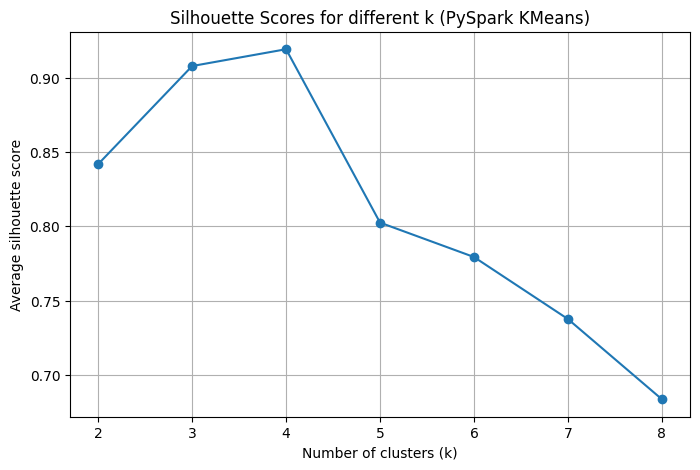

In [115]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c71, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [116]:
k_optimo = 4

In [117]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c71,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 4
- Variables utilizadas: ['total_amount_encoded', 'trip_distance_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 1228282.9474

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2716191|
|1      |339227 |
|2      |11293  |
|3      |4      |
+-------+-------+


⏱️ Tiempo de ejecución: 49.52 segundos
📊 Balance de clusters - Min: 4,  Max: 2716191, Std: 1133767.04


Un cluster sin apenas registros.

In [118]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 4,
  "silhouette_score": 0.9192260606409001,
  "wssse": 1228282.9473755807,
  "cluster_sizes": [
    [
      1,
      339227
    ],
    [
      3,
      4
    ],
    [
      2,
      11293
    ],
    [
      0,
      2716191
    ]
  ],
  "silhouette_all_k": {
    "2": 0.841903664577435,
    "3": 0.9079082764536303,
    "4": 0.9192260606409001,
    "5": 0.8025272090610828,
    "6": 0.7793690309248362,
    "7": 0.7376288872113713,
    "8": 0.6836531477631663
  },
  "centers": [
    [
      -0.3067395024787966,
      -0.00681018456261766
    ],
    [
      2.2503683369312193,
      0.03868030239174281
    ],
    [
      6.178710000219343,
      0.19608658114182276
    ],
    [
      0.30102821760985704,
      790.4883292623681
    ]
  ]
}


In [119]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c71_total_pagado_y_d__silver_clusters_20251111_125741.parquet
  Registros: 3,066,715
  Clusters únicos: 4


- **Reducción de dimensionalidad**

In [120]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c71, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [121]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


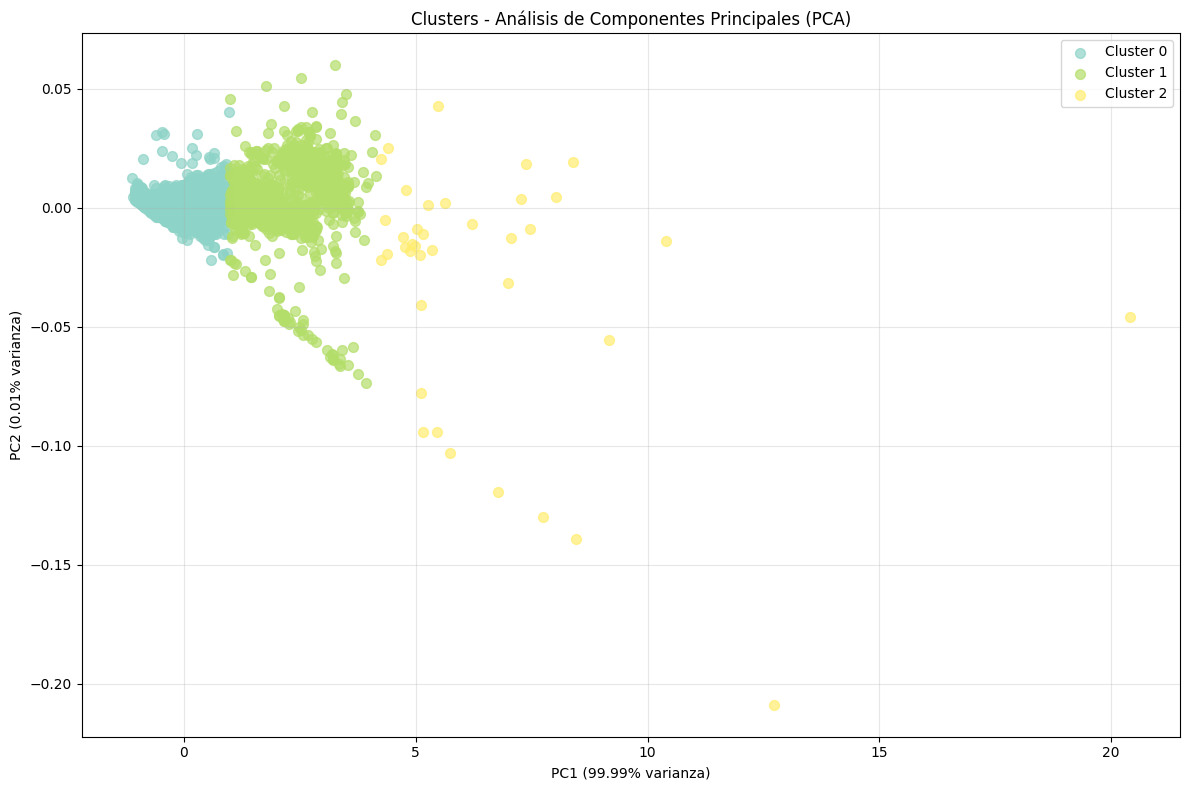

2. Perfiles de clusters...


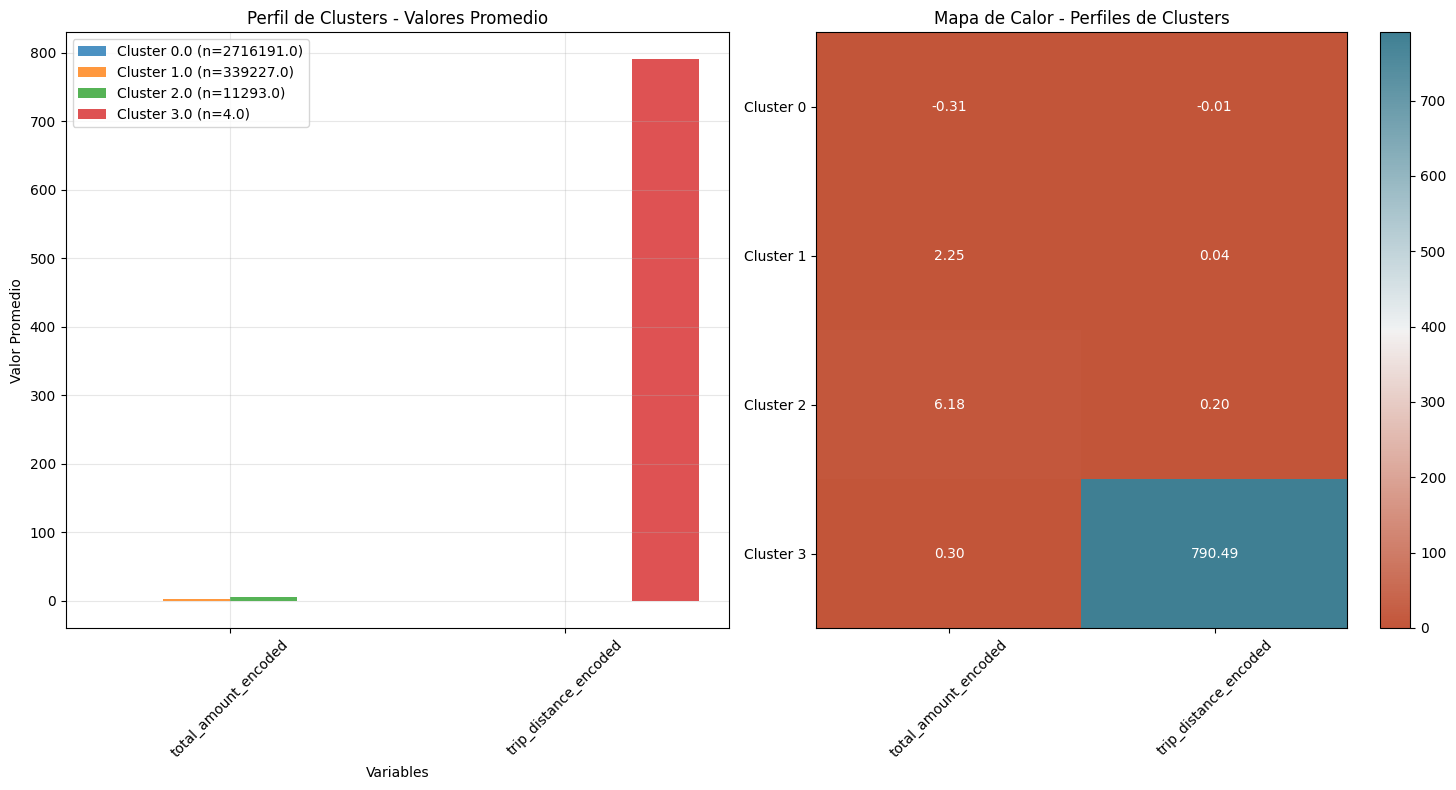

3. Distribución de clusters...


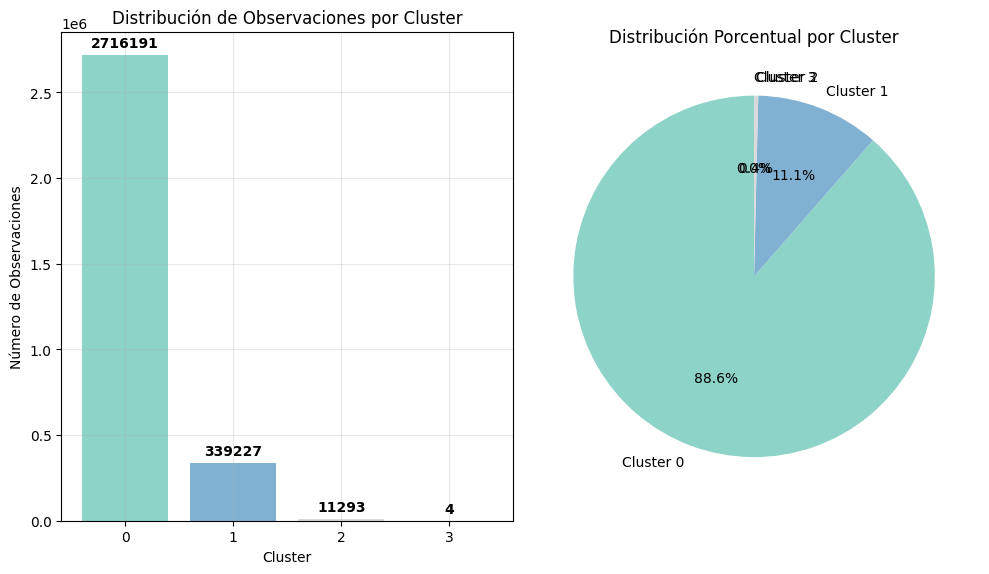

✅ Visualizaciones completadas!


In [122]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c71,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Tres grupos bien diferenciados, dos con relación 90-10 y uno muy minoritario, más un cuarto sin apenas registros. La componente principal aporta casi el 100% de la varianza.

Entre los dos grupos principales el minoritario presenta una distancia ligeramente mayor y sobre todo un importe mucho mayor. El tercer grupo destaca por su elevado importe, y el que casi no tiene registros presenta una distancia muy elevada.

El grupo mayoritario serían los viajes habituales, el minoritario viajes algo más largos y más caros, y los otros grupos representan algunos viajes mucho más caros y unos pocos muy largos.

In [123]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [124]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c71_total_pagado_y_d__silver_transformations_pca_20251111_130653.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [125]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c71_total_pagado_y_d__silver_logs_20251111_130654.parquet
  Total de registros en log: 1


In [126]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 2.25 GB / 13.61 GB (19.0%)
[Inicio] Disco usado: 42.58 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 2.25 GB / 13.61 GB (19.0%)
[Final] Disco usado: 42.58 GB / 115.66 GB (36.8%)



In [127]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 2.25 GB / 13.61 GB (19.0%)
[Inicio limpieza completa de memoria] Disco usado: 42.58 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.25 GB / 13.61 GB (19.0%)
[Final limpieza completa de memoria] Disco usado: 42.58 GB / 115.66 GB (36.8%)



**C-7-2. Propina y duración**

In [128]:
grupo_c72 = [
    "tip_amount_encoded",
    "trip_duration_minutes_encoded"
]

grupo_nombre = "C72 Propina y duración"

In [129]:
# gestión de metadatos
params = {
    "features": grupo_c72,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C72 Propina y duraci\u00f3n",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tip_amount_encoded",
      "trip_duration_minutes_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T13:06:58.338662",
  "model_version": "a422acd3a35a",
  "featureset_version": "C72 Propina y duraci\u00f3n_a422acd3a35a",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [130]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c72,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c72_propina_y_duraci__silver_features_20251111_130659.parquet
  Registros: 3,066,715
  Columnas: 7


In [131]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c72,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C72 PROPINA Y DURACIÓN
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C72 Propina y duración
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.513
Correlación máxima: 0.513
Correlación mínima: 0.513
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares


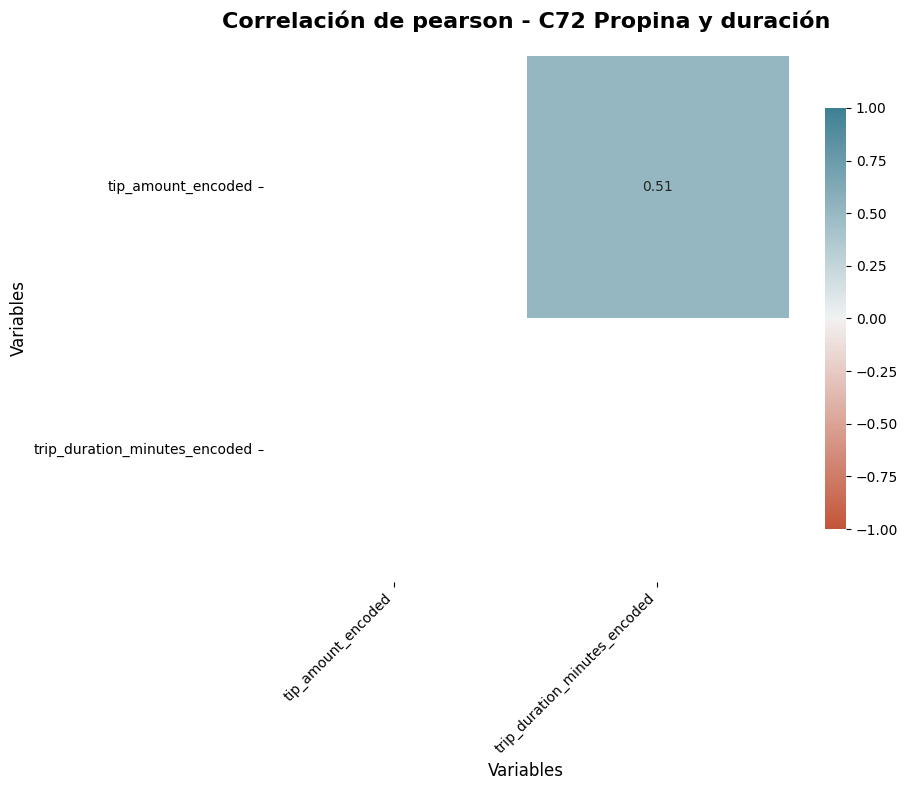


📊 ANÁLISIS DE CORRELACIÓN - C72 PROPINA Y DURACIÓN
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C72 Propina y duración
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.425
Correlación máxima: 0.425
Correlación mínima: 0.425
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares


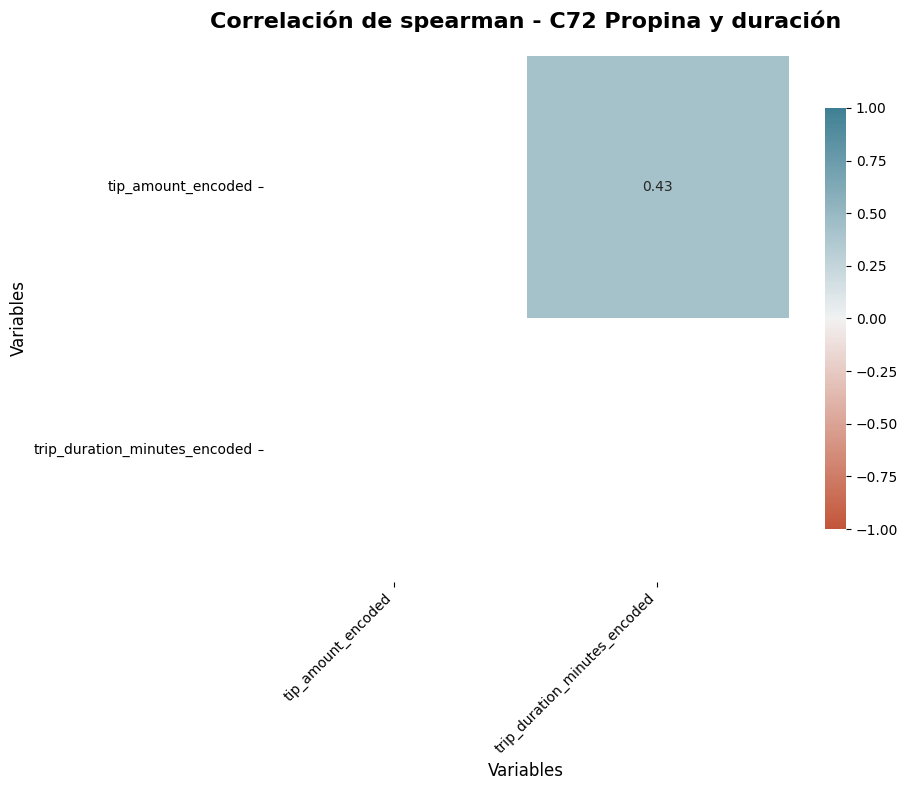

In [132]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c72,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c72,
    group_name = grupo_nombre,
    method = "spearman"
)

Correlación media lineal y no lineal.

In [133]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [134]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C72 Propina y duraci\u00f3n",
  "total_rows": 3066715,
  "variables": {
    "tip_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.8805166318031237,
      "max": 98.66864164298886,
      "mean": -3.5750195475172905e-14,
      "median": -0.1746796377329074,
      "std": 1.000000000000013,
      "q25": -0.6190955228882288,
      "q75": 0.21745202563943494,
      "n_outliers_iqr": 400704
    },
    "trip_duration_minutes_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.4157746634598511,
      "max": 4.115579432477305,
      "mean": 3.2286669690887127e-14,
      "median": -0.268072983028312,
      "std": 1.0000000000000036,
      "q25": -0.7091111833688162,
      "q75": 0.4051785121884425,
      "n_outliers_iqr": 440730
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.51

- **Análisis de VIF**

In [135]:
analyze_vif(ds_for_correlation_clean, grupo_c72)

                        Variable     VIF    Interpretacion
0             tip_amount_encoded  1.3578  Baja correlación
1  trip_duration_minutes_encoded  1.3578  Baja correlación

=== Variables con VIF aceptable ===



['tip_amount_encoded', 'trip_duration_minutes_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF muestra una baja correlación lineal.

- **Clustering**

Para k = 2, la silueta media es: 0.7857
Para k = 3, la silueta media es: 0.6372
Para k = 4, la silueta media es: 0.6322
Para k = 5, la silueta media es: 0.5331
Para k = 6, la silueta media es: 0.5429
Para k = 7, la silueta media es: 0.5757
Para k = 8, la silueta media es: 0.5373


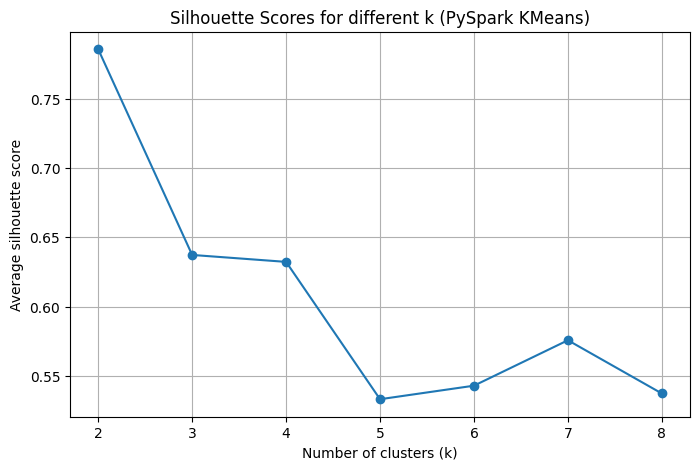

In [136]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c72, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [137]:
k_optimo = 2

In [138]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c72,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['tip_amount_encoded', 'trip_duration_minutes_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 3150990.8806

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2599979|
|1      |466736 |
+-------+-------+


⏱️ Tiempo de ejecución: 42.93 segundos
📊 Balance de clusters - Min: 466736,  Max: 2599979, Std: 1066621.50


In [139]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.7856604290138427,
  "wssse": 3150990.8806203995,
  "cluster_sizes": [
    [
      1,
      466736
    ],
    [
      0,
      2599979
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7856604290138427,
    "3": 0.6372445187174753,
    "4": 0.6322349209705901,
    "5": 0.5331492591851091,
    "6": 0.5429100219656985,
    "7": 0.5756910641742292,
    "8": 0.5372909066403091
  },
  "centers": [
    [
      -0.27984302725716126,
      -0.3102737974273856
    ],
    [
      1.5588812394338472,
      1.7283975471386552
    ]
  ]
}


In [140]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c72_propina_y_duraci__silver_clusters_20251111_132453.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [141]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c72, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [142]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


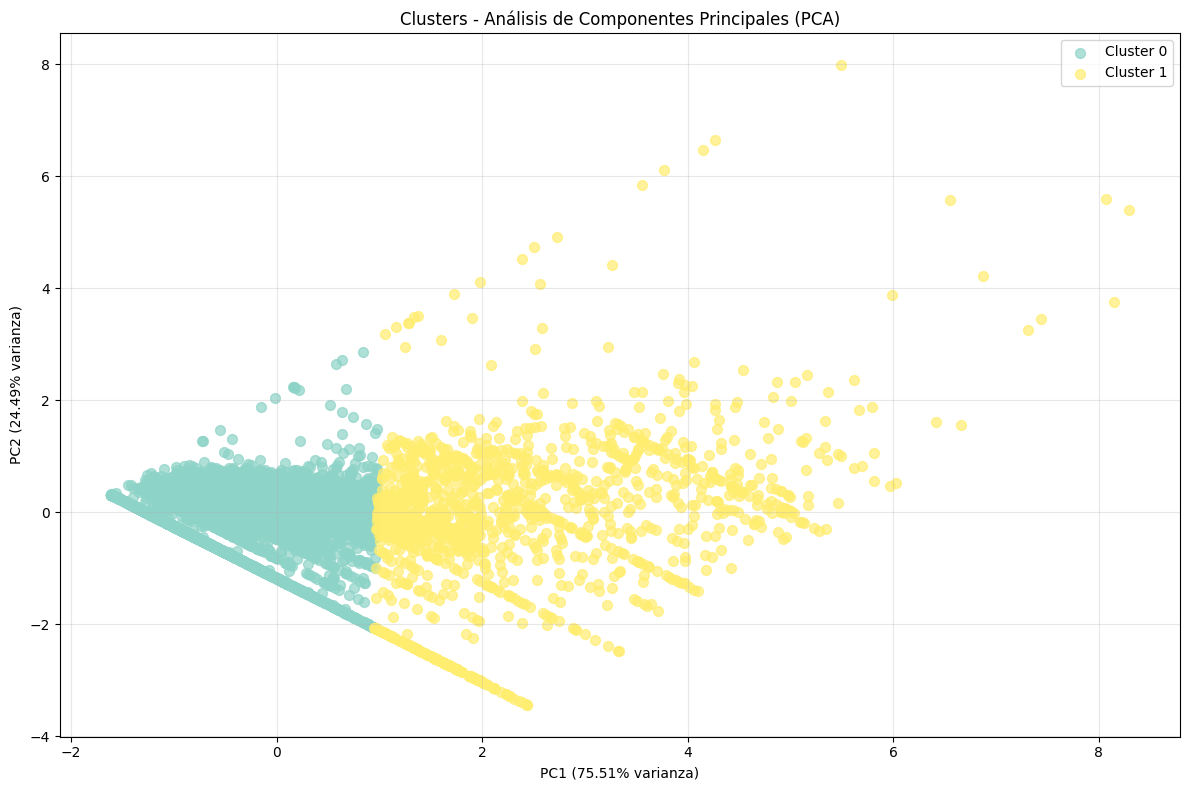

2. Perfiles de clusters...


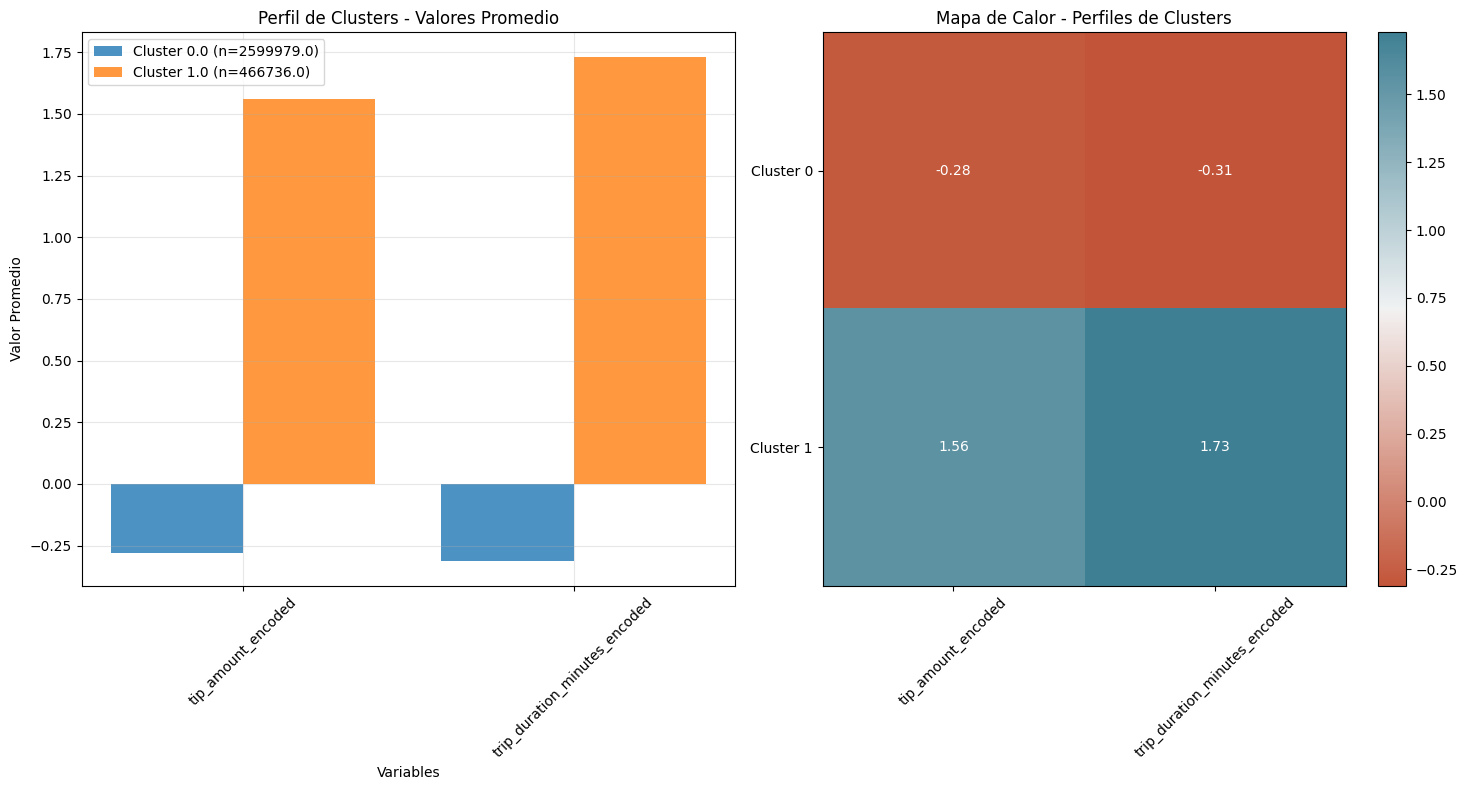

3. Distribución de clusters...


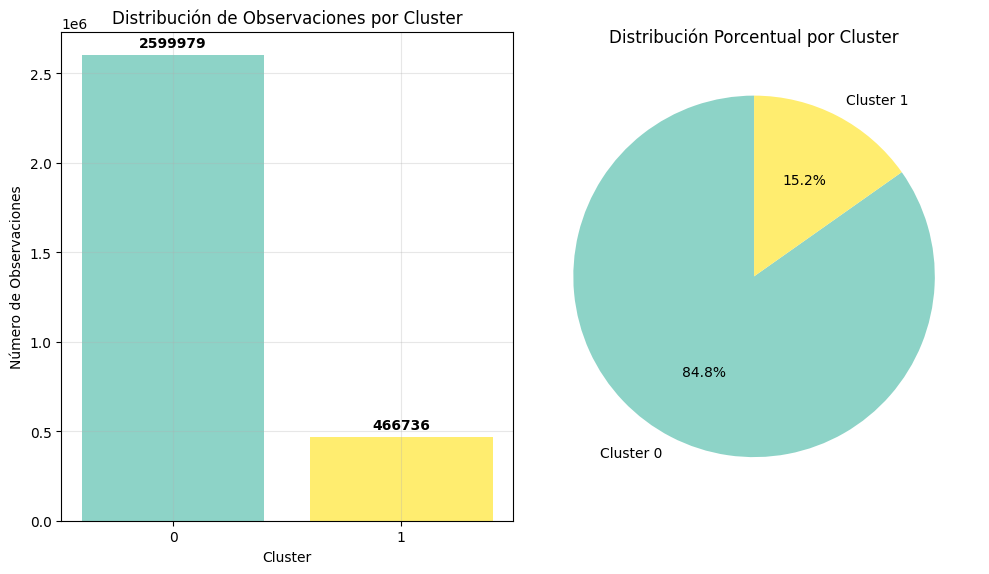

✅ Visualizaciones completadas!


In [143]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c72,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos separados, PC1 representa el 76% de la varianza.

Un grupo mayoritario, con valores medios negativos y bajos; otro grupo minoritario, con valores positivos y elevados. La mayoría de viajes son cortos y con propina baja, y algunos son largos y con propinas elevadas.

In [144]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [145]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c72_propina_y_duraci__silver_transformations_pca_20251111_133201.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [146]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c72_propina_y_duraci__silver_logs_20251111_133203.parquet
  Total de registros en log: 1


In [147]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.35 GB / 13.61 GB (49.2%)
[Inicio] Disco usado: 42.61 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.35 GB / 13.61 GB (49.2%)
[Final] Disco usado: 42.61 GB / 115.66 GB (36.8%)



In [148]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.35 GB / 13.61 GB (49.2%)
[Inicio limpieza completa de memoria] Disco usado: 42.61 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.22 GB / 13.61 GB (18.8%)
[Final limpieza completa de memoria] Disco usado: 42.61 GB / 115.66 GB (36.8%)



**C-7-3. Importe base por milla y velocidad media**

In [149]:
grupo_c73 = [
    "fare_per_mile_encoded",
    "average_speed_mph_encoded"
]

grupo_nombre = "C73 Importe base por milla y velocidad media"

In [150]:
# gestión de metadatos
params = {
    "features": grupo_c73,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C73 Importe base por milla y velocidad media",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "fare_per_mile_encoded",
      "average_speed_mph_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T13:32:07.992887",
  "model_version": "7d727439687c",
  "featureset_version": "C73 Importe base por milla y velocidad media_7d727439687c",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [151]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c73,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c73_importe_base_por__silver_features_20251111_133208.parquet
  Registros: 3,066,715
  Columnas: 7


In [152]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c73,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C73 IMPORTE BASE POR MILLA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C73 Importe base por milla y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.673
Correlación máxima: -0.673
Correlación mínima: -0.673
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares


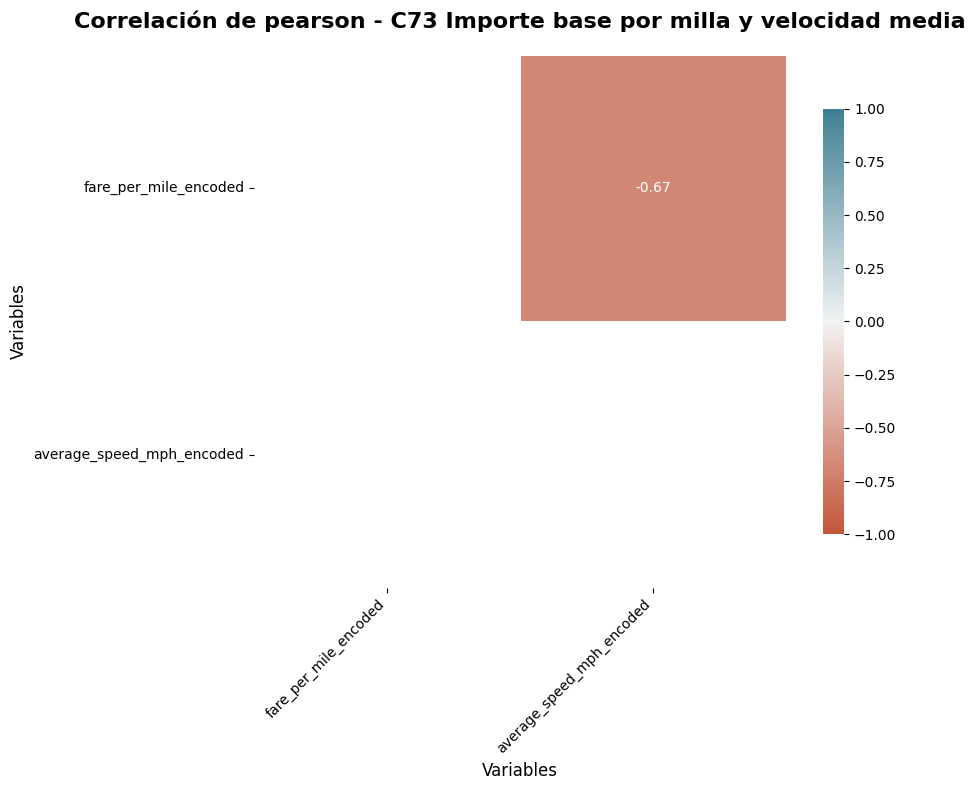


📊 ANÁLISIS DE CORRELACIÓN - C73 IMPORTE BASE POR MILLA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C73 Importe base por milla y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.837
Correlación máxima: -0.837
Correlación mínima: -0.837
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


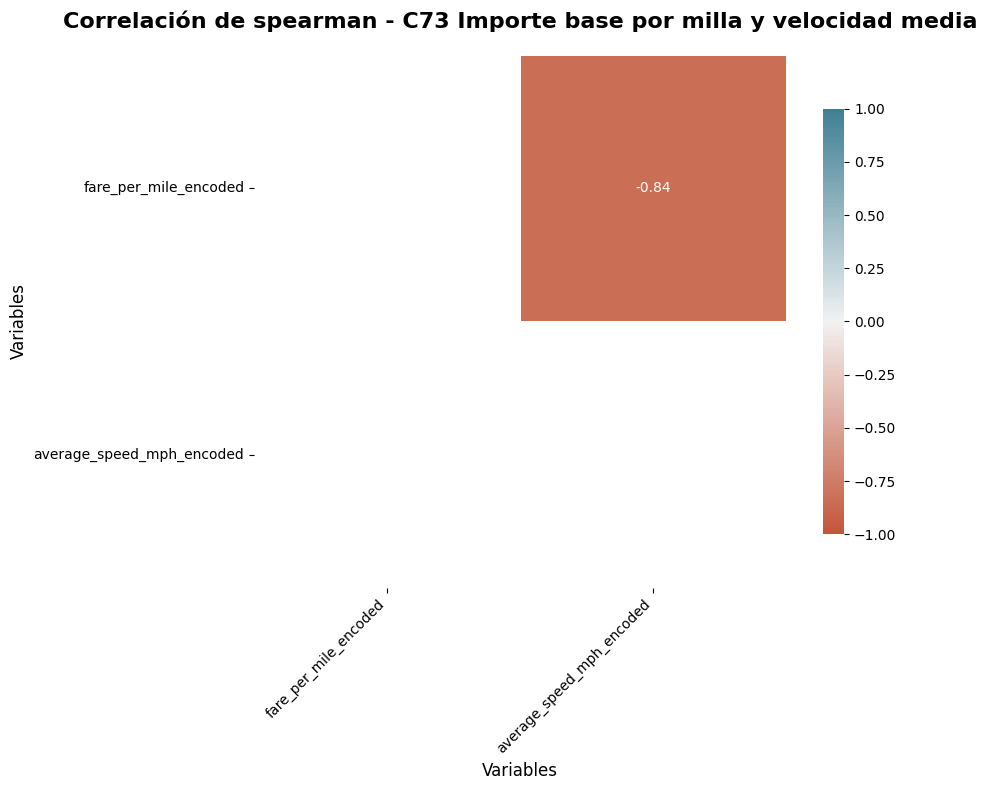

In [153]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c73,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c73,
    group_name = grupo_nombre,
    method = "spearman"
)

Correlación no lineal alta y lineal moderada.

In [154]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [155]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C73 Importe base por milla y velocidad media",
  "total_rows": 3066715,
  "variables": {
    "fare_per_mile_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -2.868975336736538,
      "max": 5.070273271175834,
      "mean": -1.3034152065937163e-13,
      "median": -0.1696446217696298,
      "std": 0.9999999999999712,
      "q25": -0.6920997782509958,
      "q75": 0.4871494942882729,
      "n_outliers_iqr": 390137
    },
    "average_speed_mph_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.817246358328061,
      "max": 4.330080642672282,
      "mean": -1.5392670307111868e-14,
      "median": -0.2882736688325687,
      "std": 0.9999999999999853,
      "q25": -0.6513810950775647,
      "q75": 0.2602028025030019,
      "n_outliers_iqr": 516638
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_co

- **Análisis de VIF**

In [156]:
analyze_vif(ds_for_correlation_clean, grupo_c73)

                    Variable     VIF    Interpretacion
0      fare_per_mile_encoded  1.8258  Baja correlación
1  average_speed_mph_encoded  1.8258  Baja correlación

=== Variables con VIF aceptable ===



['fare_per_mile_encoded', 'average_speed_mph_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF muestra una correlación lineal baja.

- **Clustering**

Para k = 2, la silueta media es: 0.6499
Para k = 3, la silueta media es: 0.6629
Para k = 4, la silueta media es: 0.6073
Para k = 5, la silueta media es: 0.6045
Para k = 6, la silueta media es: 0.5799
Para k = 7, la silueta media es: 0.5567
Para k = 8, la silueta media es: 0.5551


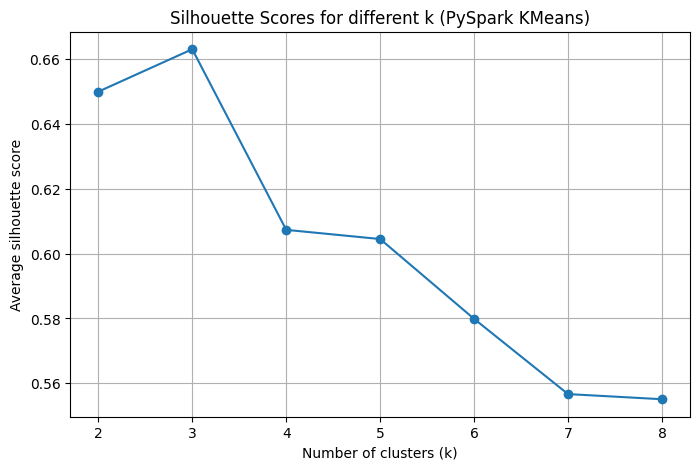

In [157]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c73, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [158]:
k_optimo = 3

In [159]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c73,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 3
- Variables utilizadas: ['fare_per_mile_encoded', 'average_speed_mph_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 1701407.3154

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1833629|
|1      |488784 |
|2      |744302 |
+-------+-------+


⏱️ Tiempo de ejecución: 51.87 segundos
📊 Balance de clusters - Min: 488784,  Max: 1833629, Std: 583145.76


In [160]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 3,
  "silhouette_score": 0.6629368303324262,
  "wssse": 1701407.3154243766,
  "cluster_sizes": [
    [
      1,
      488784
    ],
    [
      2,
      744302
    ],
    [
      0,
      1833629
    ]
  ],
  "silhouette_all_k": {
    "2": 0.6498664341211846,
    "3": 0.6629368303324262,
    "4": 0.6072926098353673,
    "5": 0.6044650152764062,
    "6": 0.5798754936922302,
    "7": 0.5566997106112486,
    "8": 0.5551187085462577
  },
  "centers": [
    [
      -0.2477024683828588,
      -0.17915850503132574
    ],
    [
      -1.153575768453627,
      1.888225361239563
    ],
    [
      1.3678984933097758,
      -0.7987187573680269
    ]
  ]
}


In [161]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c73_importe_base_por__silver_clusters_20251111_135053.parquet
  Registros: 3,066,715
  Clusters únicos: 3


- **Reducción de dimensionalidad**

In [162]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c73, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [163]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


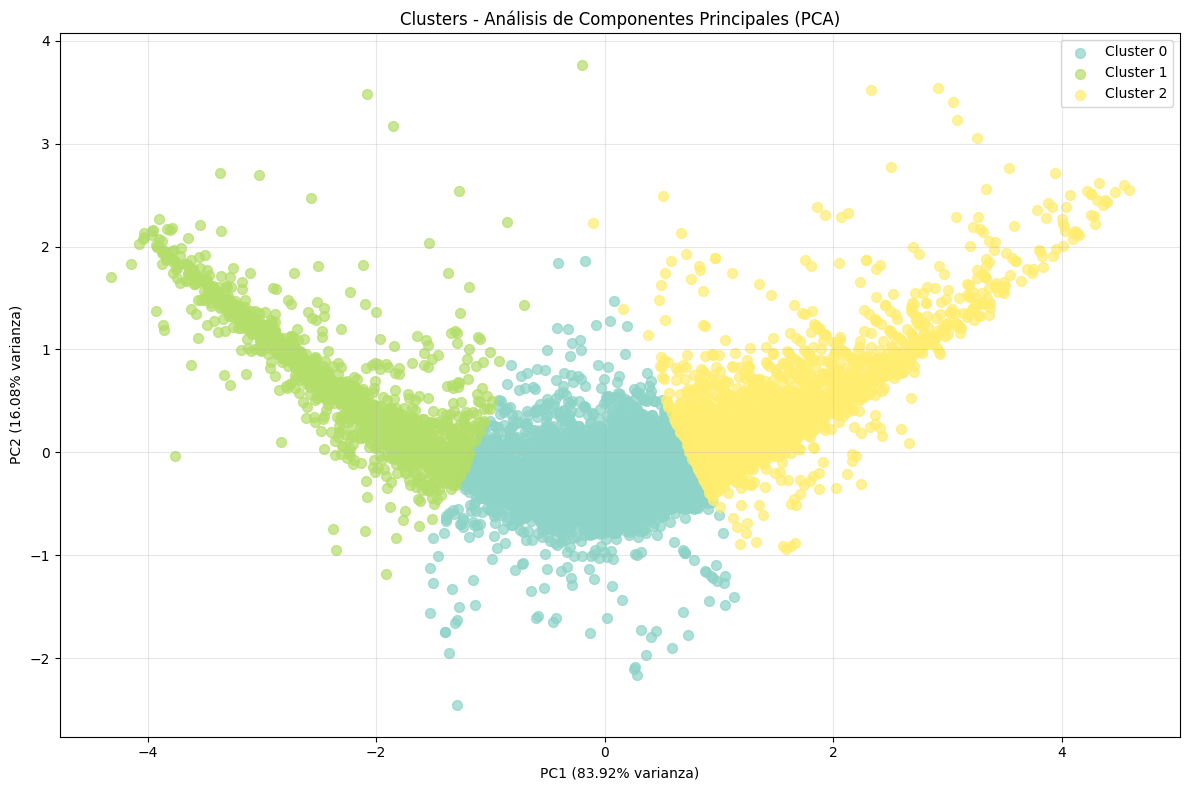

2. Perfiles de clusters...


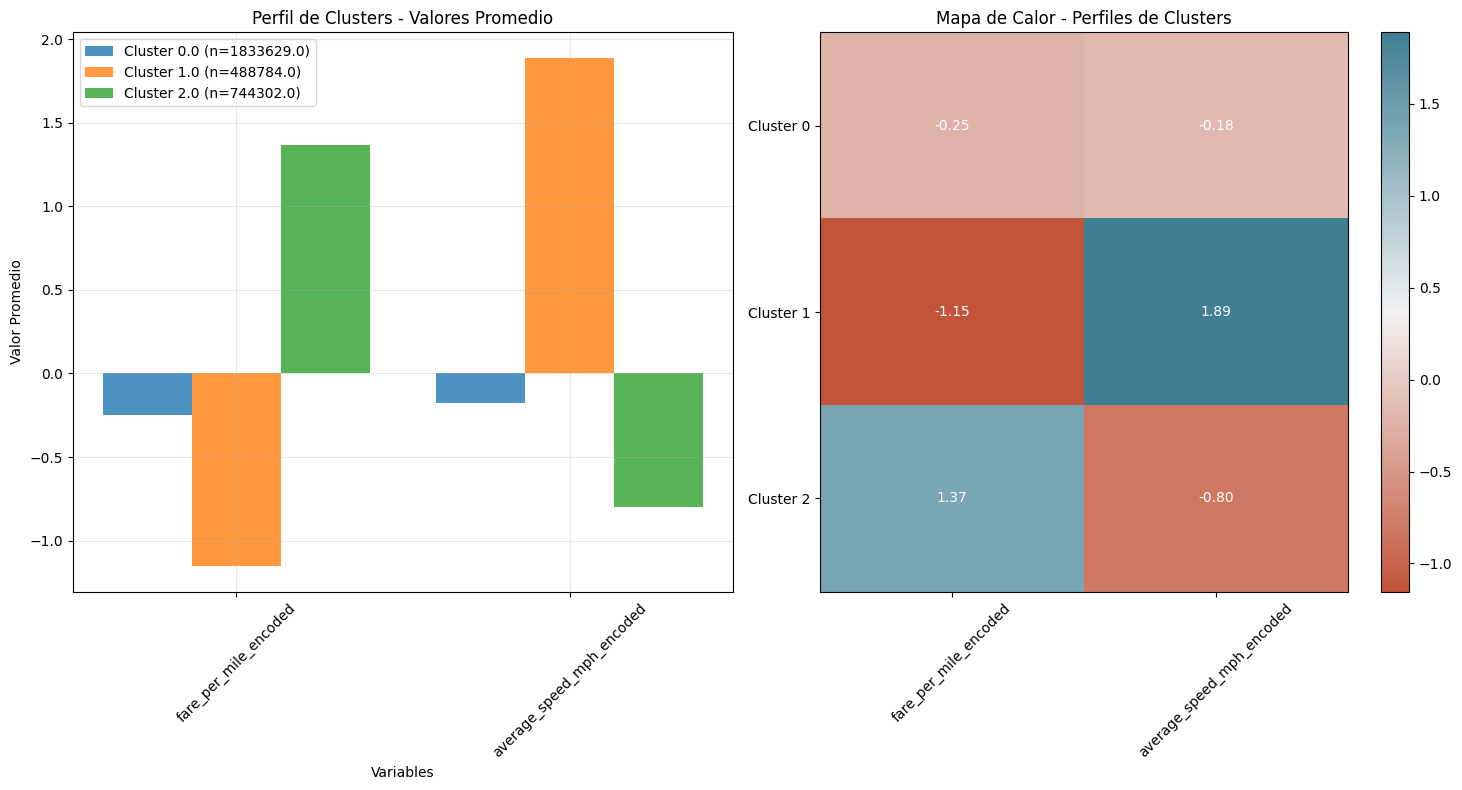

3. Distribución de clusters...


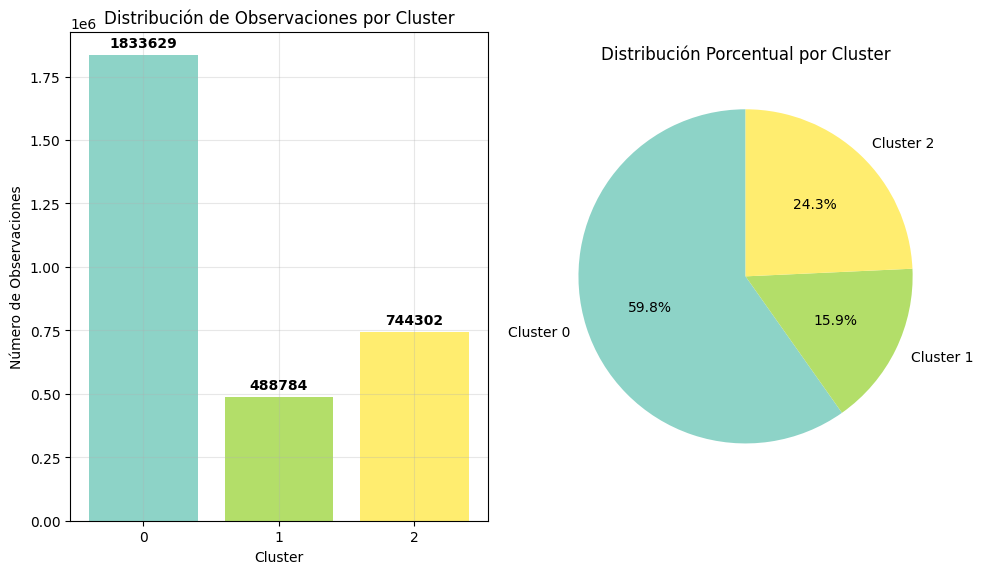

✅ Visualizaciones completadas!


In [164]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c73,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

3 clusters separados, uno bastante mayor que los otros dos. PC1 obtiene el 83% de la varianza.

El grupo principal tiene valores más bajos que los otros dos; de los otros dos, uno tiene mayor importe base por milla, y el otro mayor velocidad media.

El grupo principal serían viajes seguramente cortos y céntricos, con una velocidad baja y un importe por milla también bajo. Los otros grupos representan viajes fuera del centro, unos quizá en vías rápidas (mayor velocidad, aunque menor importe por milla) y otros por calles normales
(menor velocidad y mayor importe por milla).

In [165]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [166]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c73_importe_base_por__silver_transformations_pca_20251111_140917.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [167]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c73_importe_base_por__silver_logs_20251111_140918.parquet
  Total de registros en log: 1


In [168]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 2.20 GB / 13.61 GB (18.7%)
[Inicio] Disco usado: 42.67 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 2.20 GB / 13.61 GB (18.7%)
[Final] Disco usado: 42.67 GB / 115.66 GB (36.9%)



In [169]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 2.21 GB / 13.61 GB (18.7%)
[Inicio limpieza completa de memoria] Disco usado: 42.67 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.21 GB / 13.61 GB (18.8%)
[Final limpieza completa de memoria] Disco usado: 42.67 GB / 115.66 GB (36.9%)



**C-7-4. Total pagado y duración**

In [170]:
grupo_c74 = [
    "total_amount_encoded",
    "trip_duration_minutes_encoded"
]

grupo_nombre = "C74 Total pagado y duración"

In [171]:
# gestión de metadatos
params = {
    "features": grupo_c74,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C74 Total pagado y duraci\u00f3n",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "total_amount_encoded",
      "trip_duration_minutes_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T14:09:21.962372",
  "model_version": "07c1babfade1",
  "featureset_version": "C74 Total pagado y duraci\u00f3n_07c1babfade1",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [172]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c74,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c74_total_pagado_y_d__silver_features_20251111_140925.parquet
  Registros: 3,066,715
  Columnas: 7


In [173]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c74,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C74 TOTAL PAGADO Y DURACIÓN
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C74 Total pagado y duración
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.783
Correlación máxima: 0.783
Correlación mínima: 0.783
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


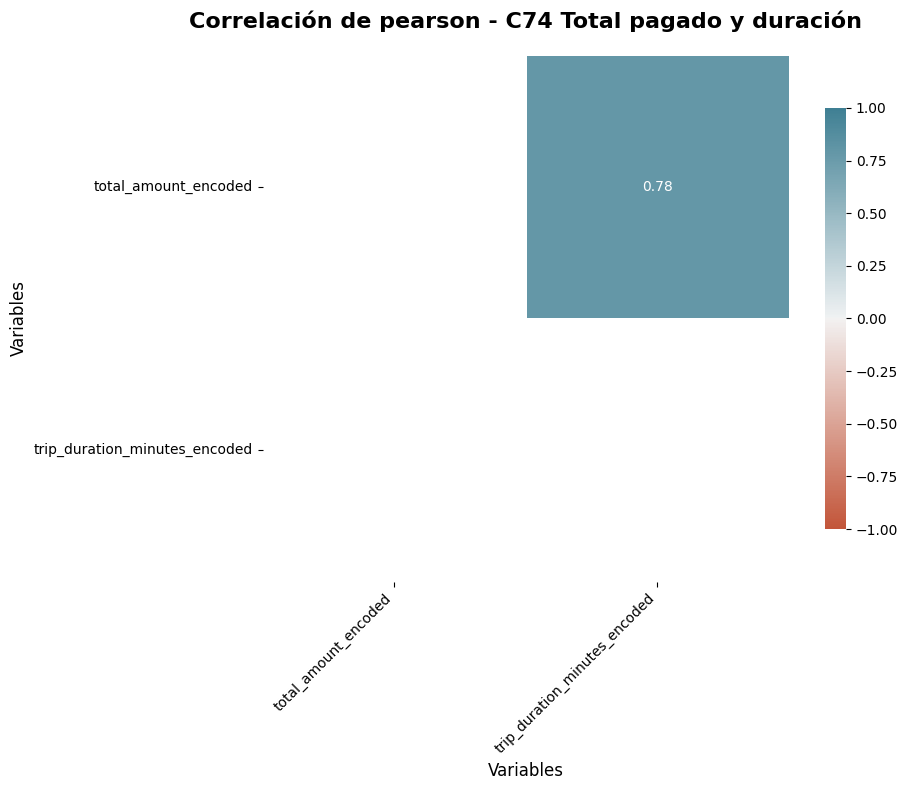


📊 ANÁLISIS DE CORRELACIÓN - C74 TOTAL PAGADO Y DURACIÓN
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C74 Total pagado y duración
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.897
Correlación máxima: 0.897
Correlación mínima: 0.897
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 0 pares


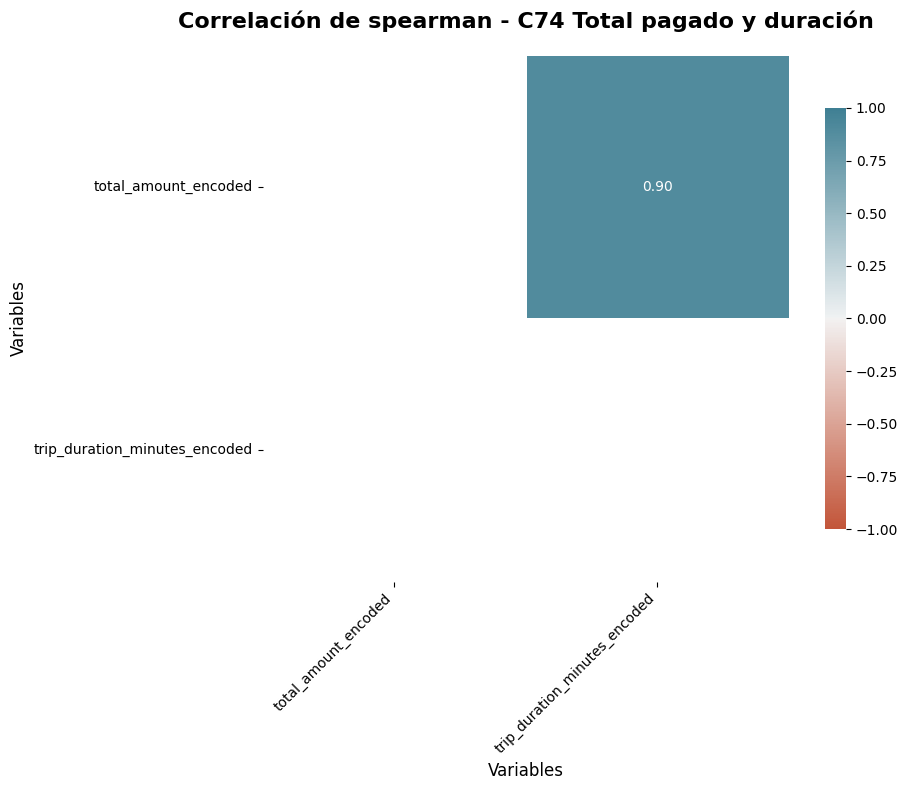

In [174]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c74,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c74,
    group_name = grupo_nombre,
    method = "spearman"
)

Alta correlación lineal y no lineal entre estas variables.

In [175]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [176]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C74 Total pagado y duraci\u00f3n",
  "total_rows": 3066715,
  "variables": {
    "total_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.2660716187785135,
      "max": 52.80343867624831,
      "mean": 1.086146817348318e-14,
      "median": -0.33438874784170847,
      "std": 1.000000000000057,
      "q25": -0.5544785972540753,
      "q75": 0.046607125930960135,
      "n_outliers_iqr": 541814
    },
    "trip_duration_minutes_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.4157746634598511,
      "max": 4.115579432477305,
      "mean": 3.2286669690887127e-14,
      "median": -0.268072983028312,
      "std": 1.0000000000000036,
      "q25": -0.7091111833688162,
      "q75": 0.4051785121884425,
      "n_outliers_iqr": 440730
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation

- **Análisis de VIF**

In [177]:
analyze_vif(ds_for_correlation_clean, grupo_c74)

                        Variable     VIF    Interpretacion
0           total_amount_encoded  2.5853  Baja correlación
1  trip_duration_minutes_encoded  2.5853  Baja correlación

=== Variables con VIF aceptable ===



['total_amount_encoded', 'trip_duration_minutes_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF muestra una baja correlación lineal entre estas variables. Esto parece contradecir la alta correlación lineal indicada por Pearson, pero hay que tener en cuenta que VIF considera todas las variables del modelo, no sólo las dos de este subgrupo.

- **Clustering**

Para k = 2, la silueta media es: 0.8429
Para k = 3, la silueta media es: 0.7088
Para k = 4, la silueta media es: 0.6534
Para k = 5, la silueta media es: 0.6609
Para k = 6, la silueta media es: 0.6323
Para k = 7, la silueta media es: 0.6532
Para k = 8, la silueta media es: 0.6331


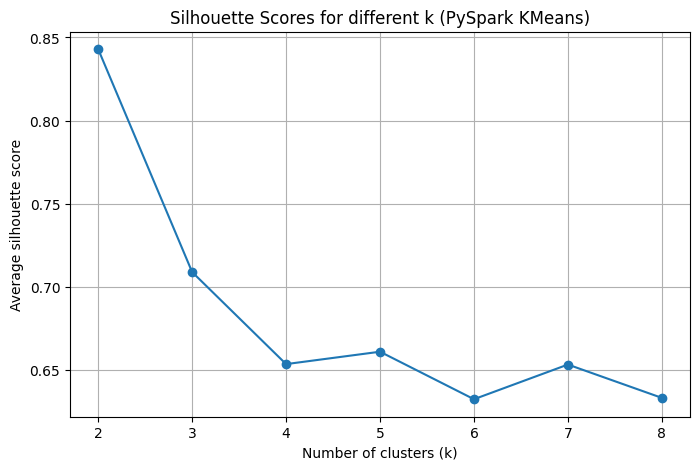

In [178]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c74, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [179]:
k_optimo = 2

In [180]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c74,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['total_amount_encoded', 'trip_duration_minutes_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 2380265.8516

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2620741|
|1      |445974 |
+-------+-------+


⏱️ Tiempo de ejecución: 40.46 segundos
📊 Balance de clusters - Min: 445974,  Max: 2620741, Std: 1087383.50


In [181]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.8428962398808134,
  "wssse": 2380265.8516270933,
  "cluster_sizes": [
    [
      1,
      445974
    ],
    [
      0,
      2620741
    ]
  ],
  "silhouette_all_k": {
    "2": 0.8428962398808134,
    "3": 0.7088008491184852,
    "4": 0.6534226428120185,
    "5": 0.66087838214763,
    "6": 0.6322941876130275,
    "7": 0.6531590452671016,
    "8": 0.6331034412960724
  },
  "centers": [
    [
      -0.3331981879594504,
      -0.31185271170487616
    ],
    [
      1.9579124320883903,
      1.8324838588303647
    ]
  ]
}


In [182]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c74_total_pagado_y_d__silver_clusters_20251111_143153.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [183]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c74, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [184]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


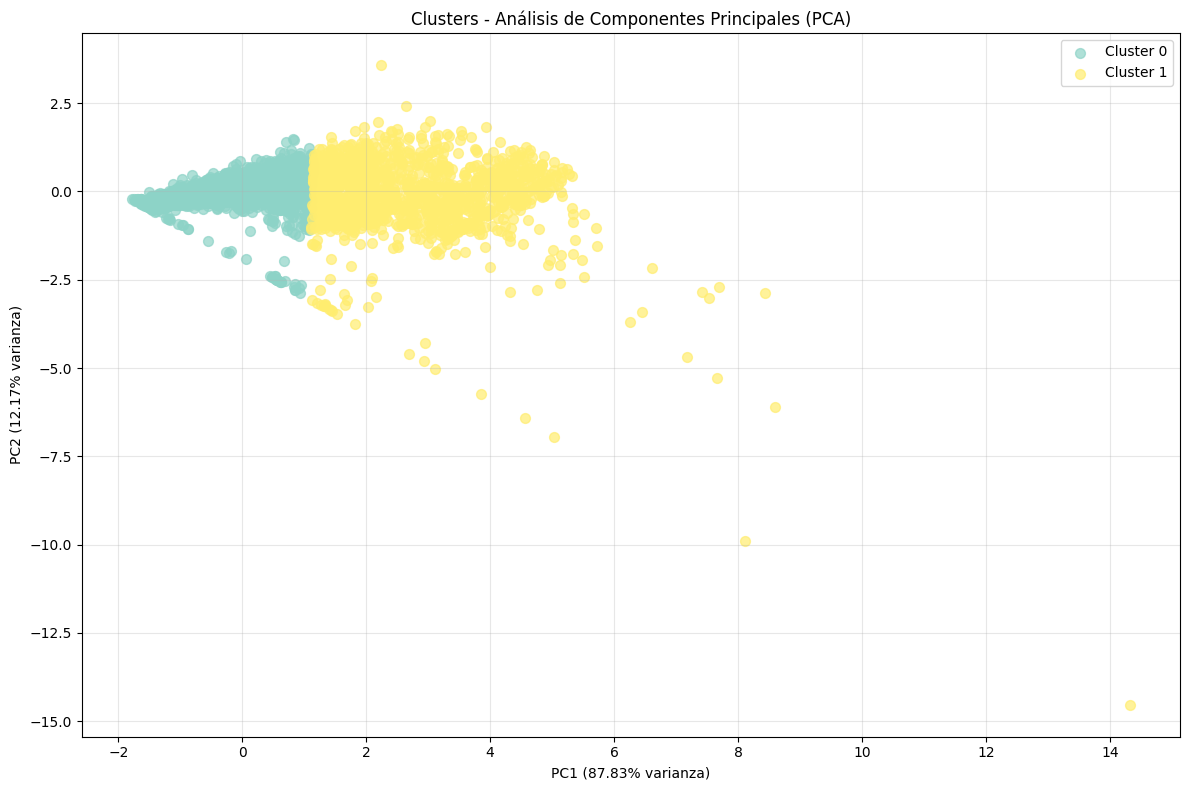

2. Perfiles de clusters...


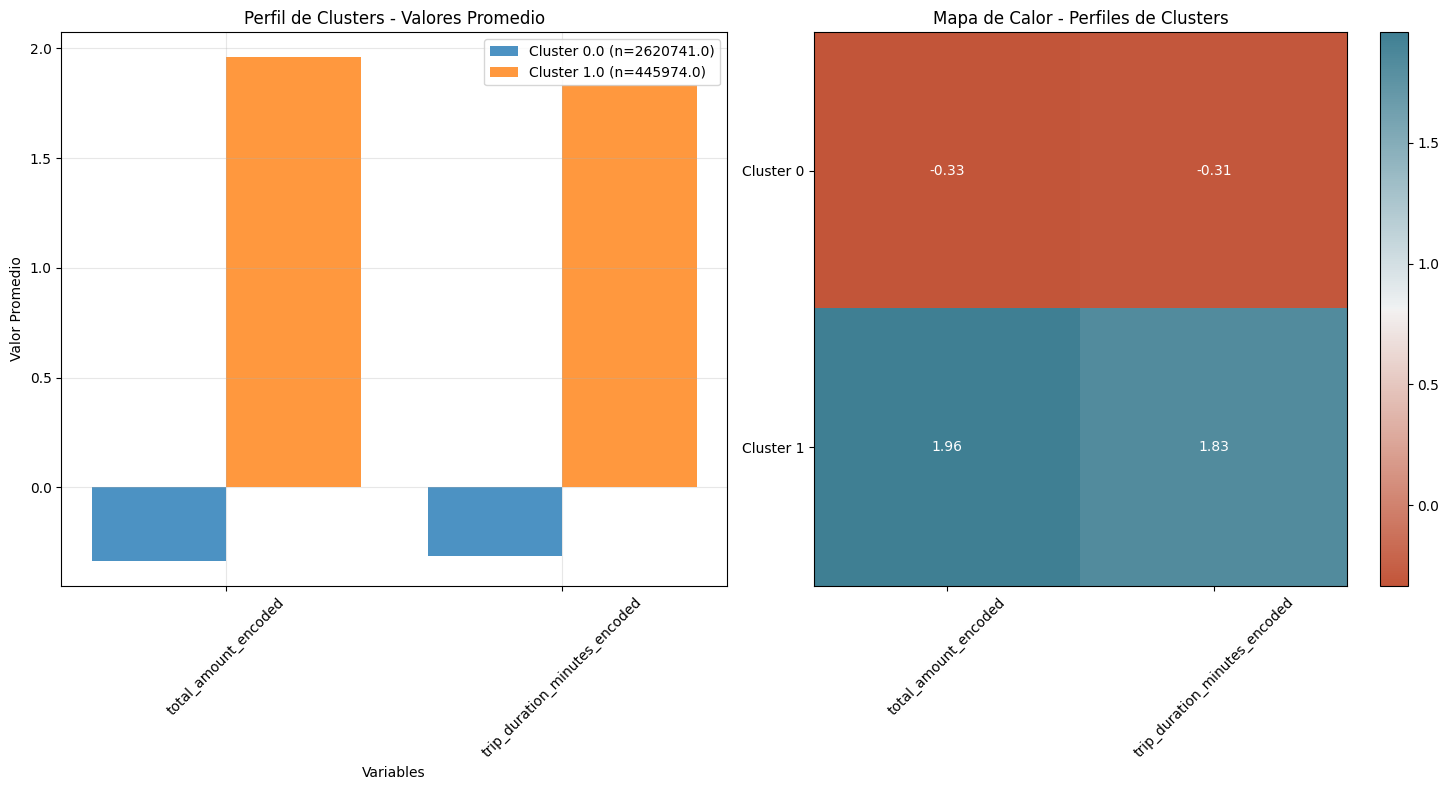

3. Distribución de clusters...


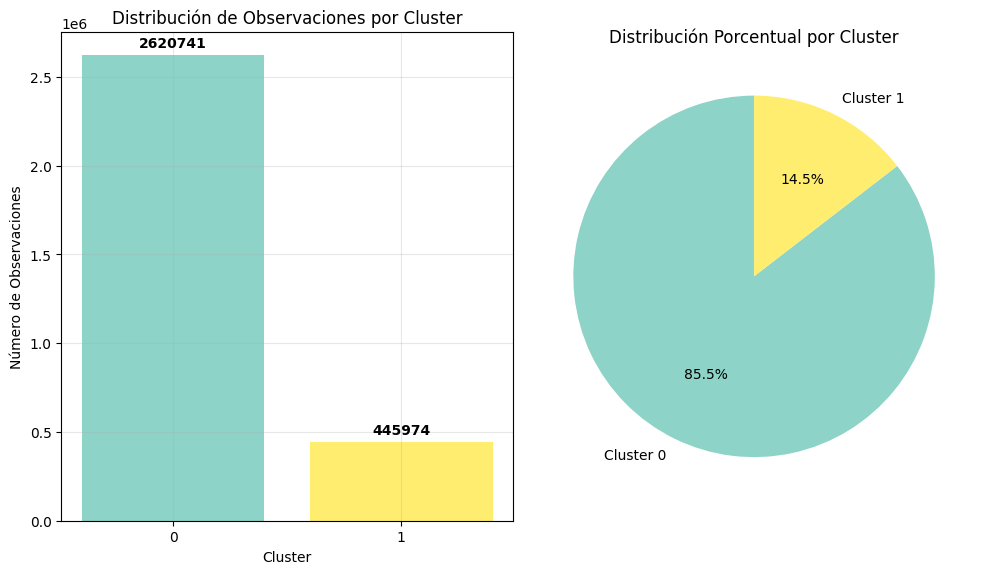

✅ Visualizaciones completadas!


In [185]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c74,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos separados, PC1 consigue casi el 90% de la varianza.

Un grupo mayoritario, valores bajos de total pagado y duración; el otro grupo, valores bastante mayores.

El grupo mayoritario serían viajes cortos y de bajo importe, el segundo grupo
serían viajes más largos, más alejados del centro, y de mayor importe.

In [186]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [187]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c74_total_pagado_y_d__silver_transformations_pca_20251111_143759.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [188]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c74_total_pagado_y_d__silver_logs_20251111_143800.parquet
  Total de registros en log: 1


In [189]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 2.26 GB / 13.61 GB (19.1%)
[Inicio] Disco usado: 42.71 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 2.26 GB / 13.61 GB (19.1%)
[Final] Disco usado: 42.71 GB / 115.66 GB (36.9%)



In [190]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 2.26 GB / 13.61 GB (19.1%)
[Inicio limpieza completa de memoria] Disco usado: 42.71 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.26 GB / 13.61 GB (19.1%)
[Final limpieza completa de memoria] Disco usado: 42.71 GB / 115.66 GB (36.9%)



**C-7-5. Cargos extra y velocidad media**

In [191]:
grupo_c75 = [
    "trip_extra_cost_ratio_encoded",
    "average_speed_mph_encoded"
]

grupo_nombre = "C75 Cargos extra y velocidad media"

In [192]:
# gestión de metadatos
params = {
    "features": grupo_c75,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C75 Cargos extra y velocidad media",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "trip_extra_cost_ratio_encoded",
      "average_speed_mph_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T14:38:04.589806",
  "model_version": "cc009f3a7256",
  "featureset_version": "C75 Cargos extra y velocidad media_cc009f3a7256",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [193]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c75,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c75_cargos_extra_y_v__silver_features_20251111_143805.parquet
  Registros: 3,066,715
  Columnas: 7


In [194]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c75,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C75 CARGOS EXTRA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C75 Cargos extra y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.472
Correlación máxima: -0.472
Correlación mínima: -0.472
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares


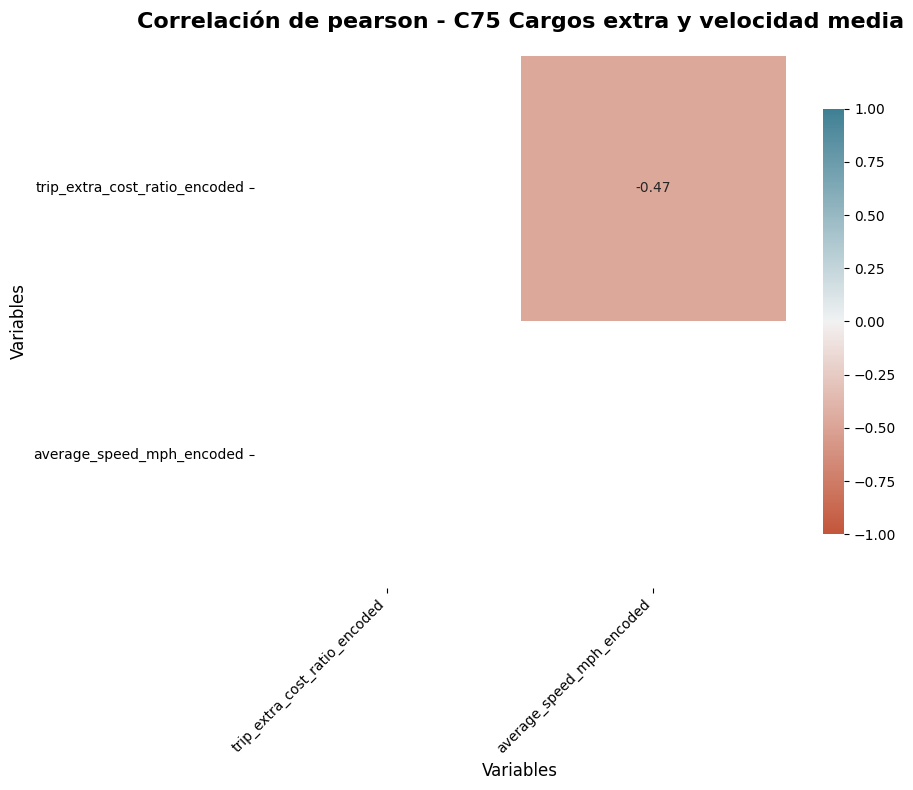


📊 ANÁLISIS DE CORRELACIÓN - C75 CARGOS EXTRA Y VELOCIDAD MEDIA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C75 Cargos extra y velocidad media
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.374
Correlación máxima: -0.374
Correlación mínima: -0.374
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 1 pares
Bajo (|r| ≤ 0.3): 0 pares


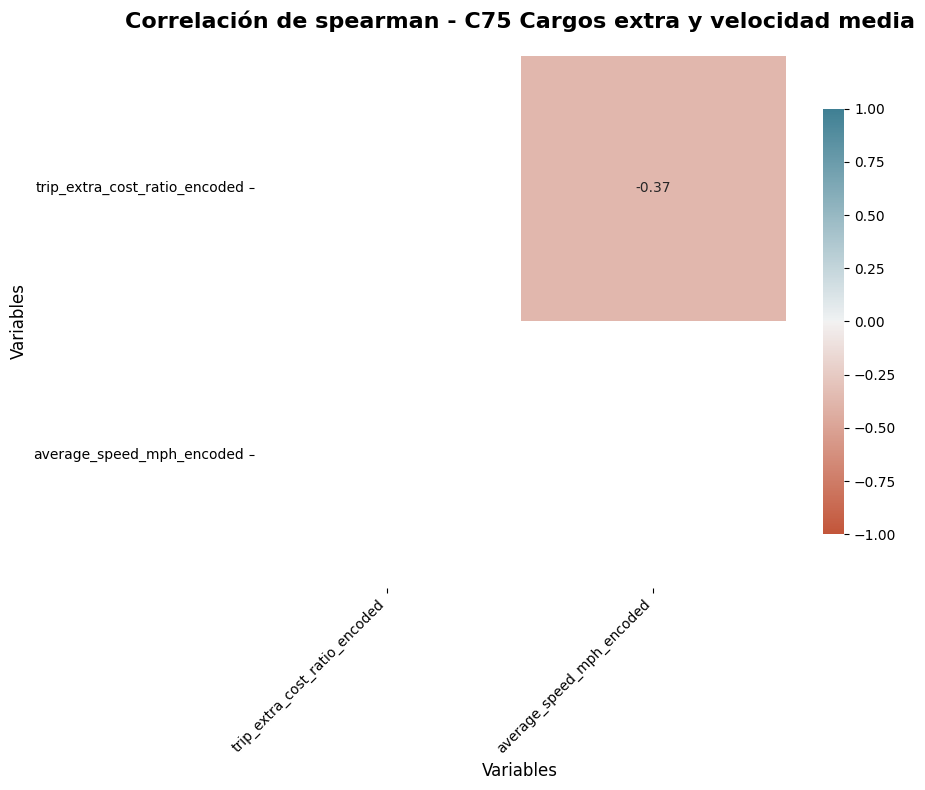

In [195]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c75,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c75,
    group_name = grupo_nombre,
    method = "spearman"
)

Correlación moderada lineal y no lineal entre estas dos variables.

In [196]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [197]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C75 Cargos extra y velocidad media",
  "total_rows": 3066715,
  "variables": {
    "trip_extra_cost_ratio_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -2.1121027176950156,
      "max": 2.3439560826480217,
      "mean": -1.0019875272525984e-13,
      "median": 0.01692680946362646,
      "std": 0.9999999999999952,
      "q25": -0.6947812163136423,
      "q75": 0.6816645552473279,
      "n_outliers_iqr": 265082
    },
    "average_speed_mph_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.817246358328061,
      "max": 4.330080642672282,
      "mean": -1.5392670307111868e-14,
      "median": -0.2882736688325687,
      "std": 0.9999999999999853,
      "q25": -0.6513810950775647,
      "q75": 0.2602028025030019,
      "n_outliers_iqr": 516638
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_co

- **Análisis de VIF**

In [198]:
analyze_vif(ds_for_correlation_clean, grupo_c75)

                        Variable     VIF    Interpretacion
0  trip_extra_cost_ratio_encoded  1.2862  Baja correlación
1      average_speed_mph_encoded  1.2862  Baja correlación

=== Variables con VIF aceptable ===



['trip_extra_cost_ratio_encoded', 'average_speed_mph_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF muestra una baja correlación lineal entre estas variables.

- **Clustering**

Para k = 2, la silueta media es: 0.7259
Para k = 3, la silueta media es: 0.5674
Para k = 4, la silueta media es: 0.5345
Para k = 5, la silueta media es: 0.4559
Para k = 6, la silueta media es: 0.5064
Para k = 7, la silueta media es: 0.5139
Para k = 8, la silueta media es: 0.4974


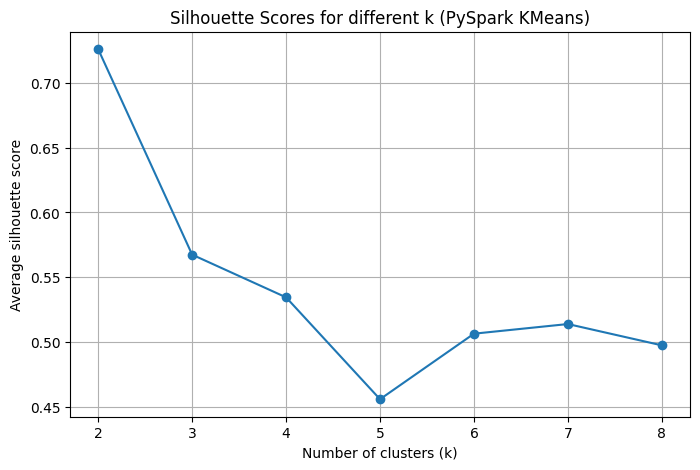

In [199]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c75, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [200]:
k_optimo = 2

In [201]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c75,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['trip_extra_cost_ratio_encoded', 'average_speed_mph_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 3034085.6139

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2410358|
|1      |656357 |
+-------+-------+


⏱️ Tiempo de ejecución: 39.56 segundos
📊 Balance de clusters - Min: 656357,  Max: 2410358, Std: 877000.50


In [202]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.7258791471022218,
  "wssse": 3034085.6138508255,
  "cluster_sizes": [
    [
      1,
      656357
    ],
    [
      0,
      2410358
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7258791471022218,
    "3": 0.567386780891896,
    "4": 0.5344576261861923,
    "5": 0.45586465314285374,
    "6": 0.5064224478051058,
    "7": 0.5138653458478842,
    "8": 0.4974279247979799
  },
  "centers": [
    [
      0.36349788736840044,
      -0.37823898499220376
    ],
    [
      -1.334924767420027,
      1.389060587729865
    ]
  ]
}


In [203]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c75_cargos_extra_y_v__silver_clusters_20251111_145239.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [204]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c75, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [205]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


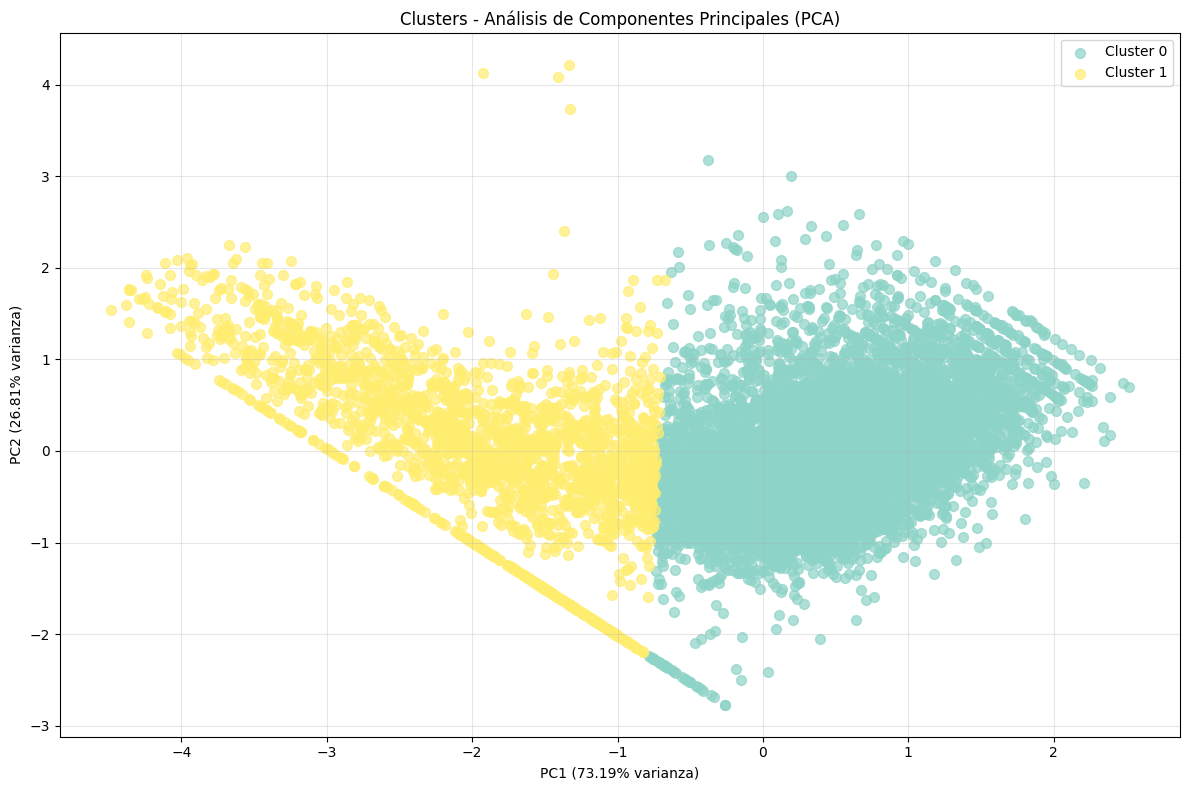

2. Perfiles de clusters...


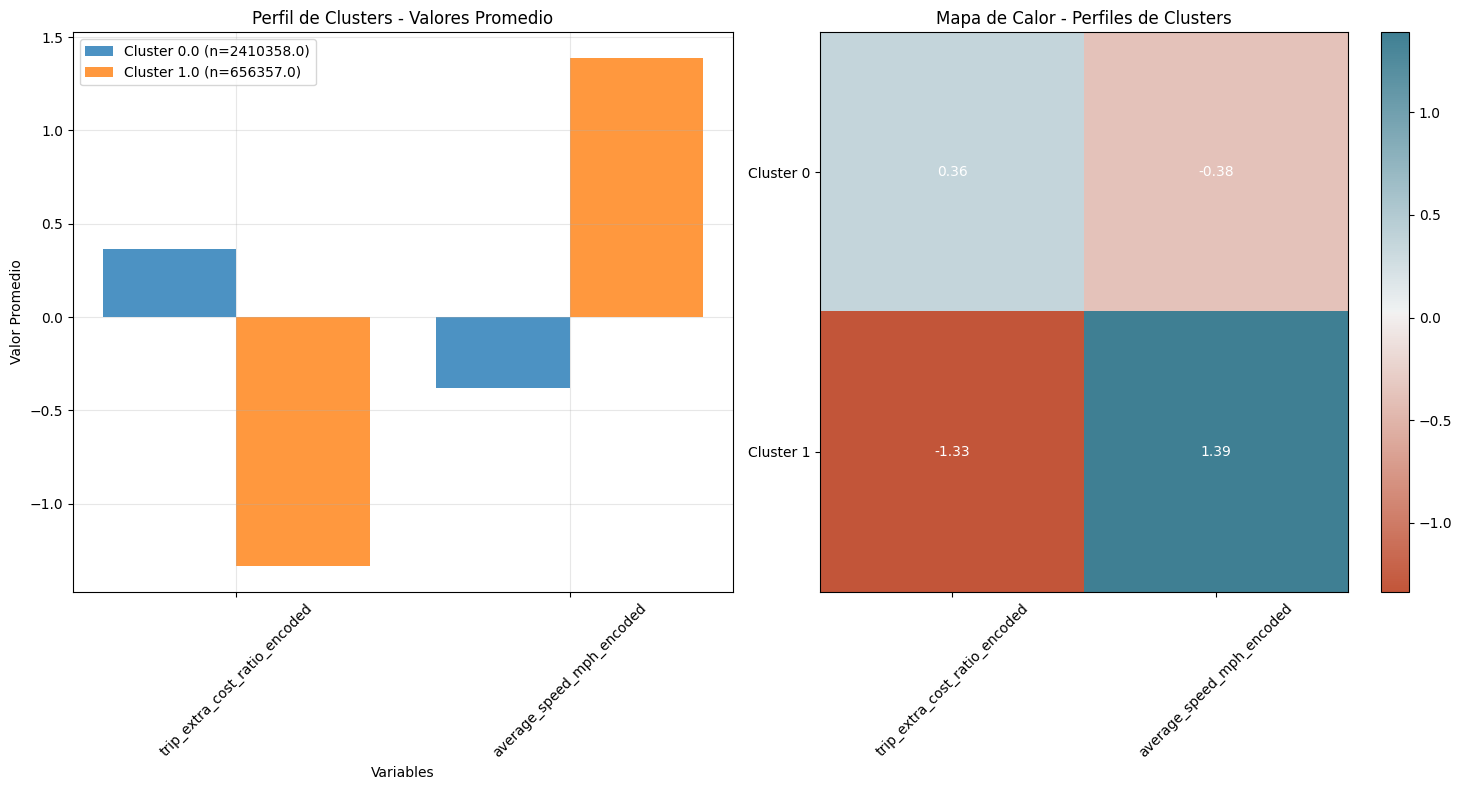

3. Distribución de clusters...


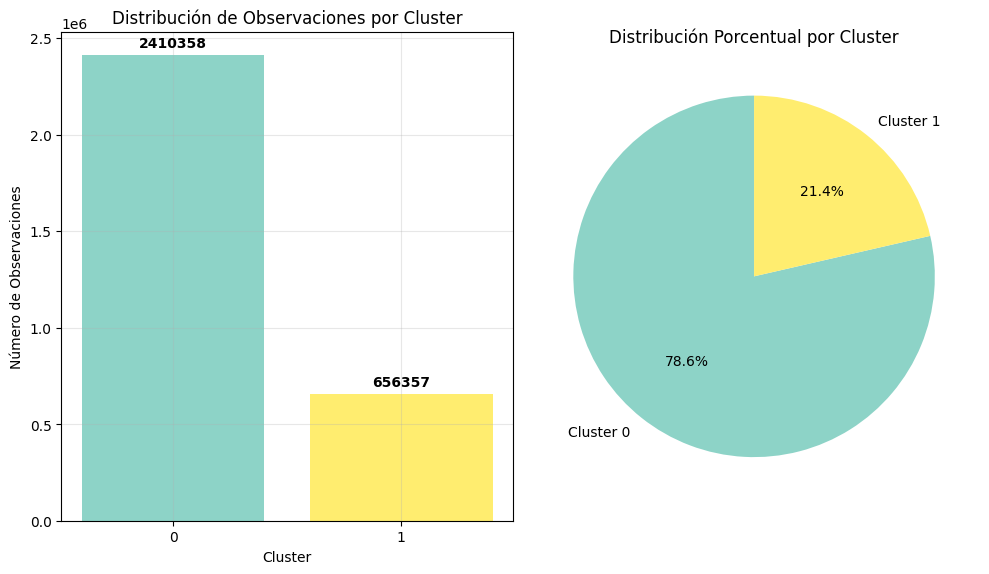

✅ Visualizaciones completadas!


In [206]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c75,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos separados, PC1 no llega al 75% de la varianza.

Un grupo mayoritario, valores bajos de cargos extra y velocidad media; el otro grupo, valores bastante más altos en ambas variables. El grupo mayoritario correspondería a trayectos urbanos, por vías de baja velocidad; el segundo grupo incluye vías de mayor velocidad, con posibles peajes o recargos de aeropuerto, por ejemplo.

El hecho de que haya correlación moderada entre estas variables y que PC1 no llegue al 75% de la varianza parece indicar que la relación es más dispersa de lo que parece.

In [207]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [208]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c75_cargos_extra_y_v__silver_transformations_pca_20251111_145850.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [209]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c75_cargos_extra_y_v__silver_logs_20251111_145852.parquet
  Total de registros en log: 1


In [210]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.38 GB / 13.61 GB (49.5%)
[Inicio] Disco usado: 42.77 GB / 115.66 GB (37.0%)


[Final] Memoria usada: 6.38 GB / 13.61 GB (49.5%)
[Final] Disco usado: 42.77 GB / 115.66 GB (37.0%)



# **4) Resumen de resultados**

- **Tratamiento de outliers y validez del clustering**

Para el clustering se ha utilizado K-Means con Standard Scaler sin eliminación de outliers. Los outliers no eliminados son valores reales válidos de las variables, pero generan magnitudes muy grandes tras el escalado. Estos valores influyen en la métrica interna de K-Means, pero no alteran de forma significativa la estructura dominante del dataset.

Por este motivo, el análisis se centra en los clusters mayoritarios; los outliers se mantienen en los datos y se interpretan por separado, evitando forzar su asignación a grupos que no describen bien su comportamiento.

Si en la capa Gold interesa confirmar si los patrones encontrados con K-Means están bien identificados, si se necesita una interpretación probabilística o si se quiere una segmentación más fina que la de K-Means, puede ser útil aplicar Gaussian Mixture Models (GMM).

- **Resumen de resultados**

En los distintos subgrupos analizados se observan patrones variados de correlación y agrupamiento. Algunos pares de variables, como "pickup_hour" y "toll_indicator_encoded", no muestran correlación significativa y se dividen en clusters claramente separados por franjas horarias, pero con peajes similares. Otros, como "total_amount" con "trip_distance" o "trip_duration", presentan correlaciones altas no lineales, reflejando la lógica de que trayectos más largos o más duraderos implican mayores importes; los clusters muestran mayorías de viajes habituales y minorías de viajes más largos o caros.

La relación entre propina y duración es moderada, con un grupo mayoritario de viajes cortos y propinas bajas y un grupo minoritario de trayectos largos y propinas altas, aunque la varianza explicada es menor que en otros subgrupos. Para "fare_per_mile" y velocidad media se observan correlaciones lineales moderadas y no lineales altas, con un grupo principal de viajes céntricos y cortos y otros grupos de viajes más alejados, diferenciados por velocidad o importe.

En "trip_extra_cost_ratio" y velocidad media se ve correlación moderada negativa: los trayectos con más cargos extra tienden a tener velocidades mayores, reflejando posibles recargos por aeropuerto o vías rápidas. En general, los clusters principales representan la mayoría de viajes cotidianos, mientras que los grupos minoritarios destacan por mayor distancia, duración, importe o velocidad, y la proporción de varianza explicada por la primera componente varía entre subgrupos, desde casi el 100% en variables muy lineales a menos del 75% en casos más dispersos.

- **Resumen de resultados por grupo**

Grupo A-1: Variables de movimiento

- trip_distance_encoded
- trip_duration_minutes_encoded
- average_speed_mph_encoded

Las tres variables están estandarizadas y sin nulos. Hay muchos outliers válidos. Pearson muestra poca relación lineal, pero Spearman confirma relaciones monotónicas fuertes entre distancia y duración. No hay multicolinealidad. El clustering detecta dos grupos reales (viajes cortos y viajes largos) y un micro-cluster residual por outliers extremos. PCA muestra que dos componentes explican toda la varianza y separan muy bien ambos grupos, dominando PC1.

Grupo A-2: Variables tarifarias

- total_amount_encoded
- fare_per_mile_encoded
- tip_amount_encoded
- extra_encoded
- mta_tax_encoded
- improvement_surcharge_encoded

Hay una relación fuerte y lógica entre total_amount, tip_amount y fare_per_mile. Los impuestos y recargos apenas cambian y solo generan correlación entre ellos. Muchos outliers, pero dentro de lo esperable. El clustering encuentra cuatro grupos, uno de ellos muy pequeño ligado a valores extremos de mta_tax e improvement_surcharge. PCA explica poca varianza y no separa bien los grupos; t-SNE sí revela una estructura no lineal clara con tres clusters principales y uno atípico.

Grupo B-1: Representaciones del día de la semana (inicio)

- tpep_pickup_datetime_dayofweek
- tpep_pickup_datetime_dayofweek_sin
- tpep_pickup_datetime_dayofweek_cos
- is_weekend

Las cuatro variables están fuertemente correladas por construcción. No hay multicolinealidad. El clustering produce 7 grupos completamente separados, correspondiendo a los 7 días. PCA explica casi toda la varianza con dos componentes. No aporta información adicional más allá de confirmar que estas variables solo codifican el día de la semana.

Grupo B-2: Representaciones de la hora (inicio)

- pickup_hour
- pickup_hour_hour_sin
- pickup_hour_hour_cos

Las tres variables están fuertemente correlacionadas según la relación matemática que las une. No hay multicolinealidad. K-Means detecta 2 clusters principales, pero internamente corresponden a las 24 horas del día codificadas en pickup_hour. PCA captura más del 98% de la varianza con el primer componente, confirmando que la información horaria está bien representada.

Grupo B-3: Representaciones del día de la semana (final)

- tpep_dropoff_datetime_dayofweek
- tpep_dropoff_datetime_dayofweek_sin
- tpep_dropoff_datetime_dayofweek_cos

Las tres variables derivadas del día de la semana de dropoff presentan correlaciones lineales y no lineales consistentes con la relación matemática entre ellas. No hay multicolinealidad.

K-Means detecta 7 clusters perfectamente separados, correspondientes a los 7 días de la semana. La primera componente principal captura cerca del 90% de la varianza, mostrando que la estructura temporal semanal está bien representada.

Grupo B-4-1. Día de la semana

- tpep_pickup_datetime_dayofweek
- tpep_dropoff_datetime_dayofweek

El día de la semana de inicio y de final del viaje está extremadamente correlacionado (≈0,99), como era de esperar; las excepciones corresponden a viajes que cruzan medianoche.

K-Means identifica 7 clusters principales, correspondientes a los 7 días de la semana, con un pequeño cluster adicional por casos atípicos. La primera componente principal captura más del 99% de la varianza, mostrando que la información temporal semanal está prácticamente contenida en una dimensión.

Grupo B-4-2. Día de la semana (sin)

- tpep_pickup_datetime_dayofweek_sin
- tpep_dropoff_datetime_dayofweek_sin

Al transformar el día de la semana con la función seno, la correlación entre inicio y final del viaje aumenta ligeramente, alcanzando ≈0,997.

K-Means identifica 7 clusters claros, correspondientes a los 7 días de la semana. La primera componente principal captura el 99,8% de la varianza, mostrando que esta transformación concentra aún más la información temporal semanal en una sola dimensión.

Grupo B-4-3. Día de la semana (cos)

- tpep_pickup_datetime_dayofweek_cos
- tpep_dropoff_datetime_dayofweek_cos

Al aplicar el coseno al día de la semana, la correlación entre inicio y final sigue siendo muy alta (≈0,997).

K-Means produce 4 clusters bien definidos: dos con valores negativos y dos con valores positivos del coseno, reflejando la periodicidad semanal pero con menor granularidad que el seno. La primera componente principal sigue explicando el 99,8% de la varianza, concentrando casi toda la información temporal en una dimensión.

Grupo B-4-4. Día del mes

- tpep_pickup_datetime_day
- tpep_dropoff_datetime_day

Para el día del mes, todas las observaciones pertenecen al mismo mes, por lo que la correlación entre inicio y final del viaje es prácticamente máxima (≈0,999).

K-Means genera 2 clusters muy separados: uno corresponde a la primera quincena (días 1-15) y otro a la segunda (días 16-31). La primera componente principal explica más del 99,9% de la varianza, y la diferencia entre los grupos se debe únicamente a esta división arbitraria de la PCA, no a diferencias reales en la distribución de los días.

Grupo C-1: Variables de ubicación y tarifas

- PULocationID_encoded
- DOLocationID_encoded
- RatecodeID_encoded

No hay correlación significativa entre estas variables. VIF confirma que no existe multicolinealidad.

K-Means separa los datos en 2 clusters: uno mayoritario (trayectos frecuentes entre zonas comunes con tarifas estándar) y otro minoritario (trayectos menos frecuentes, zonas más alejadas o tarifas especiales).

Ambas componentes principales capturan prácticamente toda la varianza, mostrando que los clusters están bien definidos.

Grupo C2: Variables de propinas

- tip_amount_encoded
- tip_score_encoded
- payment_type

Hay correlaciones moderadas entre estas variables, reflejando que el tipo de pago influye en la propina. No hay multicolinealidad.

K-Means separa los datos en 3 clusters: uno mayoritario (viajes normales, pagos habituales, propinas bajas o moderadas), otro minoritario (propinas altas, probablemente trayectos largos o tarifas elevadas) y otro intermedio (viajes menos frecuentes, predominio de ciertos métodos de pago, con porcentajes altos de propina).

Las dos primeras componentes principales capturan más del 90% de la varianza, indicando clusters bien definidos.

Grupo C3: Variables de servicio

- passenger_count_encoded
- trip_distance_encoded
- trip_duration_minutes_encoded

No hay correlación lineal significativa entre las variables, pero sí una fuerte correlación no lineal entre trip_distance_encoded y trip_duration_minutes_encoded, lo que es lógico: trayectos más largos duran más tiempo. No hay multicolinealidad.

K-Means identifica 5 clusters, aunque uno prácticamente vacío. El cluster mayoritario son viajes habituales, pocos pasajeros, trayectos cortos, duraciones bajas; los clusters minoritarios son viajes más largos, más pasajeros o mayor duración del trayecto.

Las dos primeras componentes principales capturan prácticamente el 100% de la varianza, confirmando que los clusters están bien definidos.

Grupo C4: Variables técnicas/operativas

- store_and_fwd_flag_encoded
- VendorID_encoded

No hay correlación lineal ni no lineal, ni hay multicolinealidad.

K-Means identifica 4 clusters perfectamente separados, que corresponden a las 4 combinaciones posibles de las dos variables binarias. El grupo mayoritario (0-0), datos no almacenados en el vehículo, proveedor predominante; un grupo intermedio (0-1), datos no almacenados, proveedor minoritario; y dos grupos minoritarios (1-0 y 1-1), datos almacenados en el vehículo, con ambos proveedores.

PC1 captura más del 95% de la varianza, confirmando que la separación entre los clusters es clara.

Grupo C-5-1. Zona de recogida y código de tarifa

- PULocationID_encoded
- RatecodeID_encoded

No hay correlación lineal ni no lineal, ni hay multicolinealidad.

K-Means detecta 3 clusters claros, con PC1 capturando casi el 100% de la varianza. Un cluster mayoritario (localizaciones céntricas, tarifas estándar → viajes urbanos típicos), un cluster intermedio (localizaciones y tarifas intermedias → viajes menos frecuentes dentro de la ciudad) y un cluster minoritario (localizaciones alejadas, tarifas altas → viajes fuera del centro o especiales).

Grupo C-5-2. Zona de llegada y código de tarifa

- DOLocationID_encoded
- RatecodeID_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 2 clusters claros, con PC1 capturando casi el 100% de la varianza. Un cluster mayoritario (zonas de llegada céntricas, tipo de tarifa estándar → viajes urbanos habituales) y un cluster minoritario (zonas de llegada alejadas, misma tarifa → viajes menos frecuentes fuera del centro).

Grupo C-5-3. Zona de recogida y tarifa por milla

- PULocationID_encoded
- fare_per_mile_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 3 clusters claros, con PC1 capturando casi el 100% de la varianza. Un cluster mayoritario (zonas de origen céntricas, tarifa por milla estándar → viajes urbanos habituales), un cluster intermedio (zonas de origen intermedias, tarifa normal) y un cluster minoritario (zonas de origen alejadas, tarifa por milla más elevada → viajes menos frecuentes fuera del centro).

Grupo C-5-4. Zona de llegada y cargos adicionales

- DOLocationID_encoded
- extra_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 2 clusters claros, con PC1 capturando casi el 100% de la varianza. Un cluster mayoritario (zonas de llegada céntricas, cargos adicionales estándar → viajes habituales) y un cluster minoritario (zonas de llegada alejadas del centro, cargos similares → viajes menos frecuentes fuera del centro).

Grupo C-6-1. Hora de recogida y número de pasajeros

- pickup_hour
- passenger_count_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 2 clusters, PC1 captura ~98% de la varianza. Un cluster mayoritario (horas de recogida más altas -tardes-) y un cluster minoritario (horas de recogida más bajas -mañanas/noches).

El número de pasajeros no varía significativamente entre clusters; la separación refleja sólo las horas de recogida, sin información útil sobre pasajeros.

Grupo C-6-2. Fin de semana y distancia

- is_weekend
- trip_distance_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 4 clusters, aunque dos son prácticamente anecdóticos. Un cluster mayoritario (días laborables, distancias normales), un cluster secundario (fines de semana, distancias similares) y dos clusters minoritarios (muy pocos registros, caracterizados por trayectos excepcionalmente largos).

PC1 captura ~99% de la varianza; la separación principal refleja el día de la semana, no la distancia del viaje.

Grupo C-6-3. Día de la semana y velocidad media

- tpep_pickup_datetime_dayofweek
- average_speed_mph_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means detecta 2 clusters principales: un cluster mayoritario (segunda mitad de la semana, velocidad ligeramente inferior) y un cluster secundario (primera mitad de la semana, velocidad ligeramente superior).

PC1 captura ~80% de la varianza; la separación refleja el día de la semana, pero las diferencias en velocidad media son muy pequeñas.

Grupo C-6-4. Hora de recogida y peaje

- pickup_hour
- toll_indicator_encoded

No hay correlación lineal ni no lineal ni multicolinealidad.

K-Means identifica 2 clusters principales: uno para las horas de noche y mañana, y otro para las horas de tarde.

PC1 captura ~99,8% de la varianza; los clusters reflejan únicamente franjas horarias, sin diferencias relevantes en peajes.

Grupo C-7-1. Total pagado y distancia

- total_amount_encoded
- trip_distance_encoded

No se detecta correlación lineal pero sí una correlación no lineal muy alta, lo que refleja la lógica relación entre el importe total del trayecto y la distancia recorrida.

El análisis de clusters identificó cuatro grupos: el mayoritario corresponde a los viajes habituales con importe y distancia normales, un grupo minoritario tiene trayectos algo más largos y caros, otro grupo destaca por importes muy elevados, y un cuarto grupo con apenas registros representa trayectos extremadamente largos.

La primera componente principal captura casi el 100% de la varianza, indicando que la variabilidad de los datos está prácticamente explicada por la relación entre distancia y total pagado.

Grupo C-7-2. Propina y duración

- tip_amount_encoded
- trip_duration_minutes_encoded


Existe una correlación moderada tanto lineal como no lineal, indicando que a trayectos más largos suelen corresponder propinas mayores.

El análisis de clusters identificó dos grupos: el mayoritario agrupa viajes cortos con propina baja, mientras que el minoritario corresponde a viajes más largos con propinas altas.

La primera componente principal explica el 76% de la varianza, lo que refleja que la relación entre duración y propina tiene más dispersión y no domina tanto la variabilidad del dataset.

Grupo C-7-3. Importe base por milla y velocidad media

- fare_per_mile_encoded
- average_speed_mph_encoded

Existe una correlación lineal moderada negativa y una correlación no lineal alta, indicando que viajes más rápidos tienden a tener un importe base por milla más bajo.

El análisis de clusters identificó tres grupos: el principal, que agrupa la mayoría de los viajes, tiene velocidad y tarifa por milla bajas y probablemente corresponde a trayectos cortos y céntricos; los otros dos representan viajes fuera del centro, diferenciándose uno por mayor velocidad y menor tarifa por milla, y el otro por menor velocidad y mayor tarifa.

La primera componente principal explica el 83% de la varianza, mostrando que aunque la relación es clara, hay variabilidad en la combinación de velocidad y tarifa por milla.

Grupo C-7-4. Total pagado y duración

- total_amount_encoded
- trip_duration_minutes_encoded

Presentan una alta correlación lineal y no lineal, mostrando que viajes más largos tienden a ser más caros.

El análisis de clusters identifica dos grupos: uno mayoritario con viajes cortos y de bajo importe, y otro minoritario con viajes más largos y costosos, probablemente fuera del centro.

La primera componente principal explica casi el 90% de la varianza, indicando que la duración y el importe total capturan de manera clara la variabilidad de los datos en este subgrupo.

Grupo C-7-5. Cargos extra y velocidad media

- trip_extra_cost_ratio_encoded
- average_speed_mph_encoded

Muestran una correlación moderada tanto lineal como no lineal, negativa, indicando que viajes con cargos extra más altos suelen tener velocidades medias mayores.

Se identifican dos clusters: el mayoritario, con bajos cargos extra y velocidad media baja, representando trayectos urbanos; y un grupo minoritario con ambos valores elevados, posiblemente viajes por vías rápidas o con peajes y recargos.

La primera componente principal explica menos del 75% de la varianza, mostrando que la dispersión de los datos es mayor que en otros subgrupos.

In [211]:
# limpia la memoria
ds_for_correlation_clean.unpersist()
ds_con_clusters.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, total_amount_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, fare_per_mile_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_dayofweek_sin: double, tpep_dropoff_datetime_dayofweek_cos: double, VendorID_encoded: int, store_and_fwd_flag_encoded: int, pickup_hour_hour_sin: double, pickup_hour_hour_cos: double, tip_score_encoded: double, trip_extra_cost_ratio_encoded: double, toll_indicator_encoded: int, clus

In [212]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
